# **NFL Spread Analysis**
This notebook will atempt to classify spread winners using a Linear SVC Classification model (1 = favorite win, 0 = underdog win). This Algotrithm will also atempt to predict the score of each game using the ridge regression model. Lastly a comparison between the score and spread prediction will be made as the score will also entail a spread prediction.

# 1. Problem
Predict the score of NFL games and classify the winner of the spread for each game

# 2. Data
Spread data from 2002-2023
https://www.sportsoddshistory.com/nfl-game-odds/

Additional game stats obtained from a library instructions to download can be found here:
https://www.activestate.com/blog/how-to-predict-nfl-winners-with-python/

Data Dictionary:

favorite_home:

1 - favorite team is home team <br>
0 - underdog team is home team


# 3. Features
* Week #
* Playoff or regular season game
* Home team
* Away team
* Favorite team to win
* Spread of the favorite
* Over under line
* Stadium (Dome / Stadium)
* Nutrality of stadium (Favorite Team Home or Away)
* Stadium details
* Standing / Seed


# 4. Evaluation
Using training test split set of the data.
Will make predicitions on the 2021 season games in real time.

# 5. Procedure
1. Read in NFL spread data <br>
2. Get data ready <br>
  - Remove games that have no spread values
  - Remove teams that are not in the current 32 team league
  - Convert team names to team IDs to match the spread favorites
  - Convert text to numeric values using one hot encoder
  - Convert spread to a positive value <br>
3. Feature scale necessary items <br>
4. Split data into training and testing data <br>
5. Fit the Linear SVC Model <br>
6. Fit the ridge regression model <br>
7. Evaluate findings using prediction scores and confusion matricies <br>
8. Improve the model by tuning hyper parameters
9. Save the model
10. Make visuals :)

# Data Processing

In [3]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import os

# Supress future warnings for this version of python
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from sportsreference.nfl.boxscore import Boxscores, Boxscore
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create Data Path into drive
# data_path = 'drive/MyDrive/Colab Notebooks/NFL Spread Analysis/data/'

In [4]:
# Nested dictionary containing NFL team data
nfl_teams_data = {
    'AFC': {
        'East': ['Buffalo Bills', 'Miami Dolphins', 'New England Patriots', 'New York Jets'],
        'North': ['Baltimore Ravens', 'Cincinnati Bengals', 'Cleveland Browns', 'Pittsburgh Steelers'],
        'South': ['Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars', 'Tennessee Titans'],
        'West': ['Denver Broncos', 'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Chargers']
    },
    'NFC': {
        'East': ['Dallas Cowboys', 'New York Giants', 'Philadelphia Eagles', 'Washington Commanders'],
        'North': ['Chicago Bears', 'Detroit Lions', 'Green Bay Packers', 'Minnesota Vikings'],
        'South': ['Atlanta Falcons', 'Carolina Panthers', 'New Orleans Saints', 'Tampa Bay Buccaneers'],
        'West': ['Arizona Cardinals', 'Los Angeles Rams', 'San Francisco 49ers', 'Seattle Seahawks']
    }
}

# Create a list of dictionaries for each team
teams_data = []
for conference, divisions in nfl_teams_data.items():
    for division, teams in divisions.items():
        for team in teams:
            team_data = {'conference': conference, 'division': division, 'team': team}
            teams_data.append(team_data)

# Create a DataFrame from the list of dictionaries
conferences = pd.DataFrame(teams_data)

In [6]:
def add_off_bye_columns(full_season):

  df = full_season.copy() # create a copy to work from
  df['favorite_coming_off_bye_week'] = 0
  df['underdog_coming_off_bye_week'] = 0
  bye_week_dict = {} # initialize bye week dictionary

  for team in conferences.team:

    team_active_weeks = df[(df.favorite == team) | (df.underdog == team)].week.unique()
    total_weeks = team_active_weeks.max() # Get the max amount of weeks in the season

    # Make a list of bye weeks to account for post season byes aswell
    bye_weeks = [week for week in range(1, total_weeks + 1) if week not in team_active_weeks]
    bye_week_dict[team] = bye_weeks

    # Flag all weeks where teams came off of a bye
    for bye_week in bye_weeks:
      df['favorite_coming_off_bye_week'] = df.apply(lambda x : 1 if (x.favorite == team and x.week == (bye_week + 1)) else x.favorite_coming_off_bye_week, axis = 1)
      df['underdog_coming_off_bye_week'] = df.apply(lambda x : 1 if (x.underdog == team and x.week == (bye_week + 1)) else x.underdog_coming_off_bye_week, axis = 1)

  return df

In [7]:
# Function for totaling wins / losses / ties
def add_win_loss_record(full_season):
  print('Processing Win/Loss Records...')

  df = full_season.copy() # create a copy to work from
  fav_cols = ['favorite_win_prev_game', 'favorite_loss_prev_game', 'favorite_tie_prev_game', 'favorite_cumulative_wins', 'favorite_cumulative_losses', 'favorite_cumulative_ties']
  und_cols = ['underdog_win_prev_game', 'underdog_loss_prev_game', 'underdog_tie_prev_game', 'underdog_cumulative_wins', 'underdog_cumulative_losses', 'underdog_cumulative_ties']

  df[fav_cols] = 0
  df[und_cols] = 0

  for team in conferences.team:

    # Break down needed data into the team df
    team_df = pd.DataFrame()
    team_df[['week', 'team', 'favorite', 'favorite_outright_result']] = df.apply(lambda x : pd.Series([x.week, team if (x.favorite == team or x.underdog == team) else np.nan, 1 if x.favorite == team else 0, x.favorite_outright_result]), axis = 1)
    team_df[['win', 'loss','tie']] = team_df.apply(lambda x : pd.Series([ 1 if (x.favorite == 1 and x.favorite_outright_result == 1) or (x.favorite == 0 and x.favorite_outright_result == -1) else 0,
                                                                          1 if (x.favorite == 1 and x.favorite_outright_result == -1) or (x.favorite == 0 and x.favorite_outright_result == 1) else 0,
                                                                          1 if x.favorite_outright_result == 0 else 0]), axis = 1)

    team_df.drop(['favorite_outright_result'], axis=1, inplace=True)

    # Calculate the cumulative sums for wins and losses
    team_df['cumulative_wins'] = team_df.groupby('team')['win'].cumsum()
    team_df['cumulative_losses'] = team_df.groupby('team')['loss'].cumsum()
    team_df['cumulative_ties'] = team_df.groupby('team')['tie'].cumsum()

    team_df.dropna(inplace=True)

    # Shift up dataframe by adding a week to each week so that we can see the outcome of the previous weeks game going in (add two weeks if there is no instance of a next week)

    team_df.week = team_df.week.astype(int)
    team_df.team = team_df.team.astype(str)

    # create a replacement dictionary to map the next played week to the previous (accounts for bye weeks)
    mapped_weeks = {}
    for i in range(0, len(team_df)):
      original_week = team_df.iloc[i, 0]
      try:
        week_diff = team_df.iloc[i+1, 0] - team_df.iloc[i, 0]
      except:
        # No future game so skip
        pass
      mapped_week = original_week + week_diff
      mapped_weeks[original_week] = mapped_week
    team_df['week'] = df['week'].map(mapped_weeks)


    # Shift favorite value up one to index match with the full season dataframe
    team_df['favorite'] = team_df['favorite'].shift(-1)


    # loop to add weekly scores for both favorites and underdogs
    for index, row in team_df.iterrows():
      try:
          target_index = df.loc[(df.week ==  row.week) & ((df.favorite == team) | (df.underdog == team))].index[0]
      except:
        # print('index not found, skipping week')
        continue

      if row.favorite == 1:
        df.loc[target_index, fav_cols] = [row.win, row.loss, row.tie, row.cumulative_wins, row.cumulative_losses, row.cumulative_ties]
      else:
        df.loc[target_index, und_cols] = [row.win, row.loss, row.tie, row.cumulative_wins, row.cumulative_losses, row.cumulative_ties]

  return df


In [8]:
# Function for processing the score accumulation
def add_score_accumulations(full_season):
  print('Processing Score Accumulations... ')
  df = full_season.copy() # create a copy to work from

  fav_cols = ['favorite_PF_prev_game', 'favorite_PA_prev_game', 'favorite_PD_prev_game', 'favorite_cumulative_PF', 'favorite_cumulative_PA', 'favorite_cumulative_PD']
  und_cols = ['underdog_PF_prev_game', 'underdog_PA_prev_game', 'underdog_PD_prev_game', 'underdog_cumulative_PF', 'underdog_cumulative_PA', 'underdog_cumulative_PD']

  df[fav_cols] = 0
  df[und_cols] = 0

  for team in conferences.team:


    team_df = pd.DataFrame()
    team_df[['week', 'team', 'favorite', 'favorite_score', 'underdog_score']] = df.apply(lambda x : pd.Series([x.week, team if (x.favorite == team or x.underdog == team) else np.nan, 1 if x.favorite == team else 0, x.favorite_score, x.underdog_score]), axis = 1)
    team_df[['PF', 'PA']] = team_df.apply(lambda x : pd.Series([x.favorite_score if x.favorite == 1 else x.underdog_score,
                                                                x.favorite_score if x.favorite != 1 else x.underdog_score]), axis = 1)
    team_df['PD'] = team_df['PF'] - team_df['PA']

    team_df['cumulative_PF'] = team_df.groupby('team')['PF'].cumsum()
    team_df['cumulative_PA'] = team_df.groupby('team')['PA'].cumsum()
    team_df['cumulative_PD'] = team_df.groupby('team')['PD'].cumsum()

    team_df.dropna(inplace=True)

    # Shift up dataframe by adding a week to each week so that we can see the outcome of the previous weeks game going in
    team_df.week = team_df.week.astype(int)
    team_df.team = team_df.team.astype(str)

    # create a replacement dictionary to map the next played week to the previous (accounts for bye weeks)
    mapped_weeks = {}
    for i in range(0, len(team_df)):
      original_week = team_df.iloc[i, 0]
      try:
        week_diff = team_df.iloc[i+1, 0] - team_df.iloc[i, 0]
      except:
        # No future game so skip
        pass
      mapped_week = original_week + week_diff
      mapped_weeks[original_week] = mapped_week
    team_df['week'] = df['week'].map(mapped_weeks)

    # Shift favorite value up one to index match with the full season dataframe
    team_df['favorite'] = team_df['favorite'].shift(-1)

    # loop to add weekly scores for both favorites and underdogs
    for index, row in team_df.iterrows():
      try:
        target_index = df.loc[(df.week ==  row.week) & ((df.favorite == team) | (df.underdog == team))].index[0]
      except:
        # print('index not found, skipping week')
        continue

      if row.favorite == 1:
        df.loc[target_index, fav_cols] = [row.PF, row.PA, row.PD, row.cumulative_PF, row.cumulative_PA, row.cumulative_PD]
      else:
        df.loc[target_index, und_cols] = [row.PF, row.PA, row.PD, row.cumulative_PF, row.cumulative_PA, row.cumulative_PD]

  return df

In [12]:
# Function for processing each teams seeding for entire nfl, conference and division
def add_team_season_seeding(full_season):

  print('Processing NFL Team Seeding... ')

  df = full_season.copy() # create a copy to work from
  fav_cols = ['favorite_nfl_seeding'] #, 'favorite_conference_seeding', 'favorite_division_seeding']
  und_cols = ['underdog_nfl_seeding'] #, 'favorite_conference_seeding', 'favorite_division_seeding']

  df[fav_cols] = 0
  df[und_cols] = 0

  win_sum = 0
  pf_sum = 0
  initial = True
  # Rankings for entire nfl seeding
  for week in df.week.unique():
    current_week = df[df.week == week]
    favorite_stats = current_week[['week', 'favorite', 'favorite_cumulative_wins', 'favorite_cumulative_ties', 'favorite_cumulative_losses', 'favorite_cumulative_PF', 'favorite_cumulative_PA']]
    underdog_stats = current_week[['week', 'underdog', 'underdog_cumulative_wins', 'underdog_cumulative_ties', 'underdog_cumulative_losses', 'underdog_cumulative_PF', 'underdog_cumulative_PA']]
    favorite_stats.insert(2,'fav_mark', 1)
    underdog_stats.insert(2,'fav_mark', -1)
    new_columns = ['week','team', 'favorite', 'cum_wins', 'cum_ties', 'cum_losses', 'cum_pf', 'cum_pa']

    favorite_stats.columns = new_columns
    underdog_stats.columns = new_columns
    week_df = pd.concat([favorite_stats, underdog_stats], ignore_index=True)
    sorted_week_df = week_df.sort_values(by=['cum_wins', 'cum_ties', 'cum_losses', 'cum_pf', 'cum_pa'], ascending=[False, False, True, False, True]).reset_index(drop=True).reset_index()
    sorted_week_df.rename(columns = {'index':'nfl_seed'}, inplace=True)
    sorted_week_df['nfl_seed'] = sorted_week_df['nfl_seed'].astype(int) + 1

    # Set Initial Week seedings to 0
    sorted_week_df.loc[sorted_week_df['week'] == 1, 'nfl_seed'] = 0

    if initial:
      nfl_weekly_rankings = sorted_week_df
      initial = False
    else:
      nfl_weekly_rankings = pd.concat([nfl_weekly_rankings, sorted_week_df], ignore_index = True)


  # loop to add rankings for both favorites and underdogs
  for index, row in nfl_weekly_rankings.iterrows():
    try:
      target_index = df.loc[(df.week == row.week) & ((df.favorite == row.team) | (df.underdog == row.team))].index[0]
    except:
      # print('index not found, skipping week')
      continue

    if row.favorite == 1:
      df.loc[target_index, fav_cols] = [row.nfl_seed]
    else:
      df.loc[target_index, und_cols] = [row.nfl_seed]

  return df



In [9]:
# Convert time values to labels (morning, afternoon, evening)
def categorize_time_label(time_str):
    hour = pd.to_datetime(time_str, format='%H:%M').hour
    if hour <= 2 or hour >= 10:
        return 'morning'
    elif 2 < hour <= 6 :
        return 'afternoon'
    else:
        return 'evening'

In [10]:
season_list = np.arange(2002,2024,1)
current_season = 2024
current_week = 1

In [ ]:
# Get spread stats for each season from 2002 to present
initial_pull = True
for season in season_list:

  print('Preprocessing ' + str(season) + ' season...')

  # get iterated url for each season
  url = "https://www.sportsoddshistory.com/nfl-game-season/?y=" + str(season)
  response = requests.get(url)

  # check response code error and divide the html page into its components
  if response.status_code == 200:
      html_content = response.text
      soup = BeautifulSoup(html_content, "html.parser")
  else:
      print("Failed to fetch the webpage for season: " + str(season))

  # Get all tables avaliable on the page (the table class is soh1)
  tables = soup.find_all("table", class_="soh1")

  # Create empty list to store all table data
  data = []

  print('Reading in season data...')
  for table in tables:
      # Process or extract data from each table
      rows = table.find_all("tr")
      for row in rows:
          cells = row.find_all("td")
          row_data = [cell.get_text() for cell in cells]
          data.append(row_data)

  columns = ['weekday', 'date', 'time', 'favorite_home', 'favorite', 'score_result', 'cover_result', 'underdog_home', 'underdog', 'over_under_result', 'notes']
  df = pd.DataFrame(data, columns=columns)

  # only select weelky games
  if season == current_season:
    df = df.loc[56 - (19 - current_week):]
  elif season <= 2020:
    df = df.loc[55:]
  else:
    df = df.loc[56:]

  # Differentiate playoffs and regular season
  if season == current_season and current_week <= 18:
    regular_season = df
    playoffs = df.loc[0:0]
    # test out cases for playoffs in future
  elif season <= 2019:
    regular_season = df.iloc[0:-12]
    playoffs = df.iloc[-11:]
  else:
    regular_season = df.iloc[0:-14]
    playoffs = df.iloc[-13:]

  print('Inserting game types...')
  # insert regular season as game type and remove null values
  regular_season.insert(0,'game_type', 'Regular Season')
  regular_season = regular_season.drop('notes', axis=1, inplace=False)
  regular_season = regular_season.dropna()

  print('Renaming columns...')
  # Rename columns in playoffs to match
  new_columns = ['game_type', 'weekday', 'date', 'time', 'favorite_home', 'favorite', 'score_result', 'cover_result', 'underdog_home', 'underdog', 'over_under_result']
  playoffs.columns = new_columns

  # append the two dataframes and insert the season
  frames = [regular_season, playoffs]
  full_season = pd.concat(frames)
  full_season.insert(1,'season', season)


  # The strptime function is used to parse the given string according to the specified format,
  # and then the .date() method is used to extract the date component from the resulting datetime object.
  # The %b in the format string represents the abbreviated month name (e.g., "Sep" for September),
  # %d represents the day, and %Y represents the year in four digits.

  # Define the conversion function
  convert_to_date = lambda date_string: datetime.strptime(date_string, "%b %d, %Y").date()

  # Apply the conversion function to the column
  full_season.date = full_season.date.apply(convert_to_date)

  # Make sure dataframe is soted by date
  full_season = full_season.sort_values(by='date', ascending = True)

  # define starting dates for each season -> 2012 had weird wednesday start
  if season == 2012:
    week_start_date = full_season.date.iat[0] + timedelta(days=1)
  else:
    week_start_date = full_season.date.iat[0]

  # loop through to add week numbers
  week_num_list = []
  week_num = 1
  for index, row in full_season.iterrows():
    date = row.date
    weekday = row.weekday

    if date >= week_start_date + timedelta(days=7):
      week_num += 1
      week_start_date = week_start_date + timedelta(days=7)

    week_num_list.append(week_num)

  # insert week numbers into the dataframe
  full_season.insert(2,'week', week_num_list)

  # replace favorite home with 1 for home, 0 for away
  full_season.favorite_home = full_season.favorite_home.replace('', -1)
  full_season.favorite_home = full_season.favorite_home.replace('N', 0)
  full_season.favorite_home = full_season.favorite_home.replace('@', 1).astype(int)
  full_season.drop('underdog_home', axis=1, inplace=True)


  # Split the win result column
  full_season[['favorite_outright_result', 'favorite_score', 'underdog_score']] = full_season.score_result.str.split().apply(lambda x: pd.Series([x[0], *x[1].split('-')]))
  full_season.drop('score_result', axis=1, inplace=True)

  # Split the cover_result
  full_season[['favorite_spread_result', 'spread']] = full_season.cover_result.str.split(' ', expand=True)
  full_season.drop('cover_result', axis=1, inplace=True)

  # Split the over/under result
  full_season[['over_under_result', 'over_under']] = full_season.over_under_result.str.split(' ', expand=True)
  tmp = full_season.over_under_result
  full_season.drop('over_under_result', axis=1, inplace=True)
  full_season.insert(14,'over_under_result', tmp)

  # Convert datatypes to int and encode (W T L) and (O P U) into (1 0 -1)
  full_season.favorite_outright_result = full_season.favorite_outright_result.replace('L', -1)
  full_season.favorite_outright_result = full_season.favorite_outright_result.replace('T', 0)
  full_season.favorite_outright_result = full_season.favorite_outright_result.replace('W', 1).astype(int)

  full_season.favorite_spread_result = full_season.favorite_spread_result.replace('L', -1)
  full_season.favorite_spread_result = full_season.favorite_spread_result.replace('P', 0)
  full_season.favorite_spread_result = full_season.favorite_spread_result.replace('W', 1).astype(int)

  full_season.over_under_result	= full_season.over_under_result.replace('U', -1)
  full_season.over_under_result	= full_season.over_under_result.replace('P', 0)
  full_season.over_under_result	= full_season.over_under_result.replace('O', 1).astype(int)

  full_season.favorite_score	= full_season.favorite_score.astype(int)
  full_season.underdog_score = full_season.underdog_score.astype(int)

  # Fix pk issue with spread scores by manufacturing a spread

  # Case when favorite wins teh spread
  full_season.spread = full_season.apply(lambda x : x.underdog_score - x.favorite_score + 0.5 if (x.favorite_spread_result == 1 and x.spread == 'PK') else x.spread, axis = 1 )
  # Case when favorite loses the spread but wins the game
  full_season.spread = full_season.apply(lambda x : x.underdog_score - x.favorite_score - 0.5 if (x.favorite_spread_result == -1 and x.spread == 'PK' and x.underdog_score < x.favorite_score) else x.spread, axis = 1 )
  # Case where favorite loses the spread and loses the game
  full_season.spread = full_season.apply(lambda x : -0.5 if (x.favorite_spread_result == -1 and x.spread == 'PK' and x.underdog_score > x.favorite_score) else x.spread, axis = 1 )

  full_season.spread = full_season.spread.astype(float)
  full_season.over_under = full_season.over_under.astype(float)


  # Extract month and day from date object
  full_season.date = pd.to_datetime(full_season.date)
  years = full_season.date.dt.year.astype(int)
  months = full_season.date.dt.month.astype(int)
  days = full_season.date.dt.day.astype(int)

  full_season.insert(2,'year', years)
  full_season.insert(3,'month', months)
  full_season.insert(4,'day', days)
  full_season.drop('date', axis=1, inplace=True)

  # add playoffs indicator
  playoffs = full_season.apply(lambda x: 0  if x['game_type'] == 'Regular Season' else 1, axis = 1)
  full_season.insert(0, 'playoffs', playoffs)

  # Add seeding column and strip seeding values from playoff games
  full_season['favorite_playoff_conf_seeding'] = full_season.apply(lambda x: int(x.favorite[-2]) if x.playoffs == 1 else 0 , axis = 1)
  full_season['underdog_playoff_conf_seeding'] = full_season.apply(lambda x: int(x.underdog[-2]) if x.playoffs == 1 else 0, axis = 1)
  full_season['favorite'] = full_season.apply(lambda x: x.favorite[:-4] if x.playoffs == 1 else x.favorite , axis = 1)
  full_season['underdog'] = full_season.apply(lambda x: x.underdog[:-4] if x.playoffs == 1 else x.underdog, axis = 1)

  # Fix any name that has changed since 2002
  full_season= full_season.replace('Dal', 'Dallas Cowboys')
  full_season= full_season.replace('Washington Football Team', 'Washington Commanders')
  full_season= full_season.replace('Washington Redskins', 'Washington Commanders')
  full_season= full_season.replace('St Louis Rams', 'Los Angeles Rams')
  full_season= full_season.replace('Oakland Raiders', 'Las Vegas Raiders')
  full_season= full_season.replace('San Diego Chargers', 'Los Angeles Chargers')

  # Merge Conference data to favorites
  fav_confs = full_season.merge(conferences, how = 'left', left_on = 'favorite', right_on = 'team')
  full_season.insert(9, 'favorite_conf', list(fav_confs.conference))
  full_season.insert(10, 'favorite_div', list(fav_confs.division))

  # Merge Conference data to underdogs
  und_confs = full_season.merge(conferences, how = 'left', left_on = 'underdog', right_on = 'team')
  full_season.insert(12, 'underdog_conf', list(und_confs.conference))
  full_season.insert(13, 'underdog_div', list(und_confs.division))

  # Add bye
  full_season = add_off_bye_columns(full_season)

  # Add the win/loss/tie record and previous game outcome for every team and full nfl rankings
  full_season = add_win_loss_record(full_season)
  full_season = add_score_accumulations(full_season)
  full_season = add_team_season_seeding(full_season)

  # Add in score projections based on the over under total and spread preds
  full_season['favorite_projected_score'] = (full_season.over_under / 2) - (full_season.spread/2)
  full_season['underdog_projected_score'] = (full_season.over_under / 2) + (full_season.spread/2)

  # Add in the actual spread value and actual total in the game
  full_season['actual_spread'] = full_season.underdog_score - full_season.favorite_score
  full_season['actual_total_score'] = full_season.underdog_score + full_season.favorite_score

  # Categorize the time starts
  full_season['time'] = full_season['time'].apply(categorize_time_label)

  if initial_pull:
    final_df = full_season
    initial_pull = False
  else:
    final_df = pd.concat([final_df, full_season], ignore_index=True)

  print('Preprocessing ' + str(season) + ' season complete!')
  print('')

print('Preprocessing all seasons complete!')

# Save dataset to drive (so you dont have to wait to process again)
print('Saving processed data to data folder')
final_df.to_csv('../data/2002_to_2023_seasons_processed.csv', index = False)
print('Saved!')

Preprocessing 2002 season...
Reading in season data...
Inserting game types...
Renaming columns...
Processing Win/Loss Records...
Processing Score Accumulations... 
Processing NFL Team Seeding... 
Preprocessing 2002 season complete!

Preprocessing 2003 season...
Reading in season data...
Inserting game types...
Renaming columns...
Processing Win/Loss Records...
Processing Score Accumulations... 
Processing NFL Team Seeding... 
Preprocessing 2003 season complete!

Preprocessing 2004 season...
Reading in season data...
Inserting game types...
Renaming columns...
Processing Win/Loss Records...
Processing Score Accumulations... 
Processing NFL Team Seeding... 
Preprocessing 2004 season complete!

Preprocessing 2005 season...
Reading in season data...
Inserting game types...
Renaming columns...
Processing Win/Loss Records...
Processing Score Accumulations... 
Processing NFL Team Seeding... 
Preprocessing 2005 season complete!

Preprocessing 2006 season...
Reading in season data...
Inserting

In [ ]:
full_season.head()

playoffs       game_type  season  year  month  day  week weekday  \
56         0  Regular Season    2023  2023      9    7     1     Thu   
70         0  Regular Season    2023  2023      9   10     1     Sun   
69         0  Regular Season    2023  2023      9   10     1     Sun   
68         0  Regular Season    2023  2023      9   10     1     Sun   
66         0  Regular Season    2023  2023      9   10     1     Sun   

         time favorite_conf favorite_div  favorite_home underdog_conf  \
56    evening           AFC         West              1           NFC   
70    evening           NFC         East             -1           NFC   
69  afternoon           NFC         West              1           NFC   
68  afternoon           NFC         East             -1           AFC   
66  afternoon           AFC         West              1           AFC   

   underdog_div             favorite              underdog  \
56        North   Kansas City Chiefs         Detroit Lions   
70         East       Dallas Cowboys       New York Giants   
69         West     Seattle Seahawks      Los Angeles Rams   
68         East  Philadelphia Eagles  New England Patriots   
66         West       Denver Broncos     Las Vegas Raiders   

    favorite_outright_result  favorite_score  underdog_score  \
56                        -1              20              21   
70                         1              40               0   
69                        -1              13              30   
68                         1              25              20   
66                        -1              16              17   

    favorite_spread_result  spread  over_under_result  over_under  \
56                      -1    -4.0                 -1        53.5   
70                       1    -3.0                 -1        46.5   
69                      -1    -5.5                 -1        46.5   
68                       1    -4.0                 -1        45.5   
66                      -1    -2.5                 -1        44.5   

    favorite_playoff_conf_seeding  underdog_playoff_conf_seeding  \
56                              0                              0   
70                              0                              0   
69                              0                              0   
68                              0                              0   
66                              0                              0   

    favorite_coming_off_bye_week  underdog_coming_off_bye_week  \
56                             0                             0   
70                             0                             0   
69                             0                             0   
68                             0                             0   
66                             0                             0   

    favorite_win_prev_game  favorite_loss_prev_game  favorite_tie_prev_game  \
56                       0                        0                       0   
70                       0                        0                       0   
69                       0                        0                       0   
68                       0                        0                       0   
66                       0                        0                       0   

    favorite_cumulative_wins  favorite_cumulative_losses  \
56                         0                           0   
70                         0                           0   
69                         0                           0   
68                         0                           0   
66                         0                           0   

    favorite_cumulative_ties  underdog_win_prev_game  underdog_loss_prev_game  \
56                         0                       0                        0   
70                         0                       0                        0   
69                         0                       0                      

: 

# Data Cleaning

In [ ]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# ML imports
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# from sportsreference.nfl.boxscore import Boxscores, Boxscore
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create Data Path into drive
data_path = 'drive/MyDrive/Colab Notebooks/NFL Spread Analysis/data/'

In [ ]:
# Read in processed data from file path
nfl_df = pd.read_csv(data_path + '2002_to_2023_seasons_processed.csv')

# Data Viz

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# from sportsreference.nfl.boxscore import Boxscores, Boxscore
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create Data Path into drive
data_path = 'drive/MyDrive/Colab Notebooks/NFL Spread Analysis/data/'

In [2]:
# Read in processed data from file path
nfl_df = pd.read_csv(data_path + '2002_to_2023_seasons_processed.csv')

In [3]:
# Read in processed data from file path
spread_odds = pd.read_csv(data_path + 'nfl_spread_odds.csv')

## Feature Correlation Heatmaps

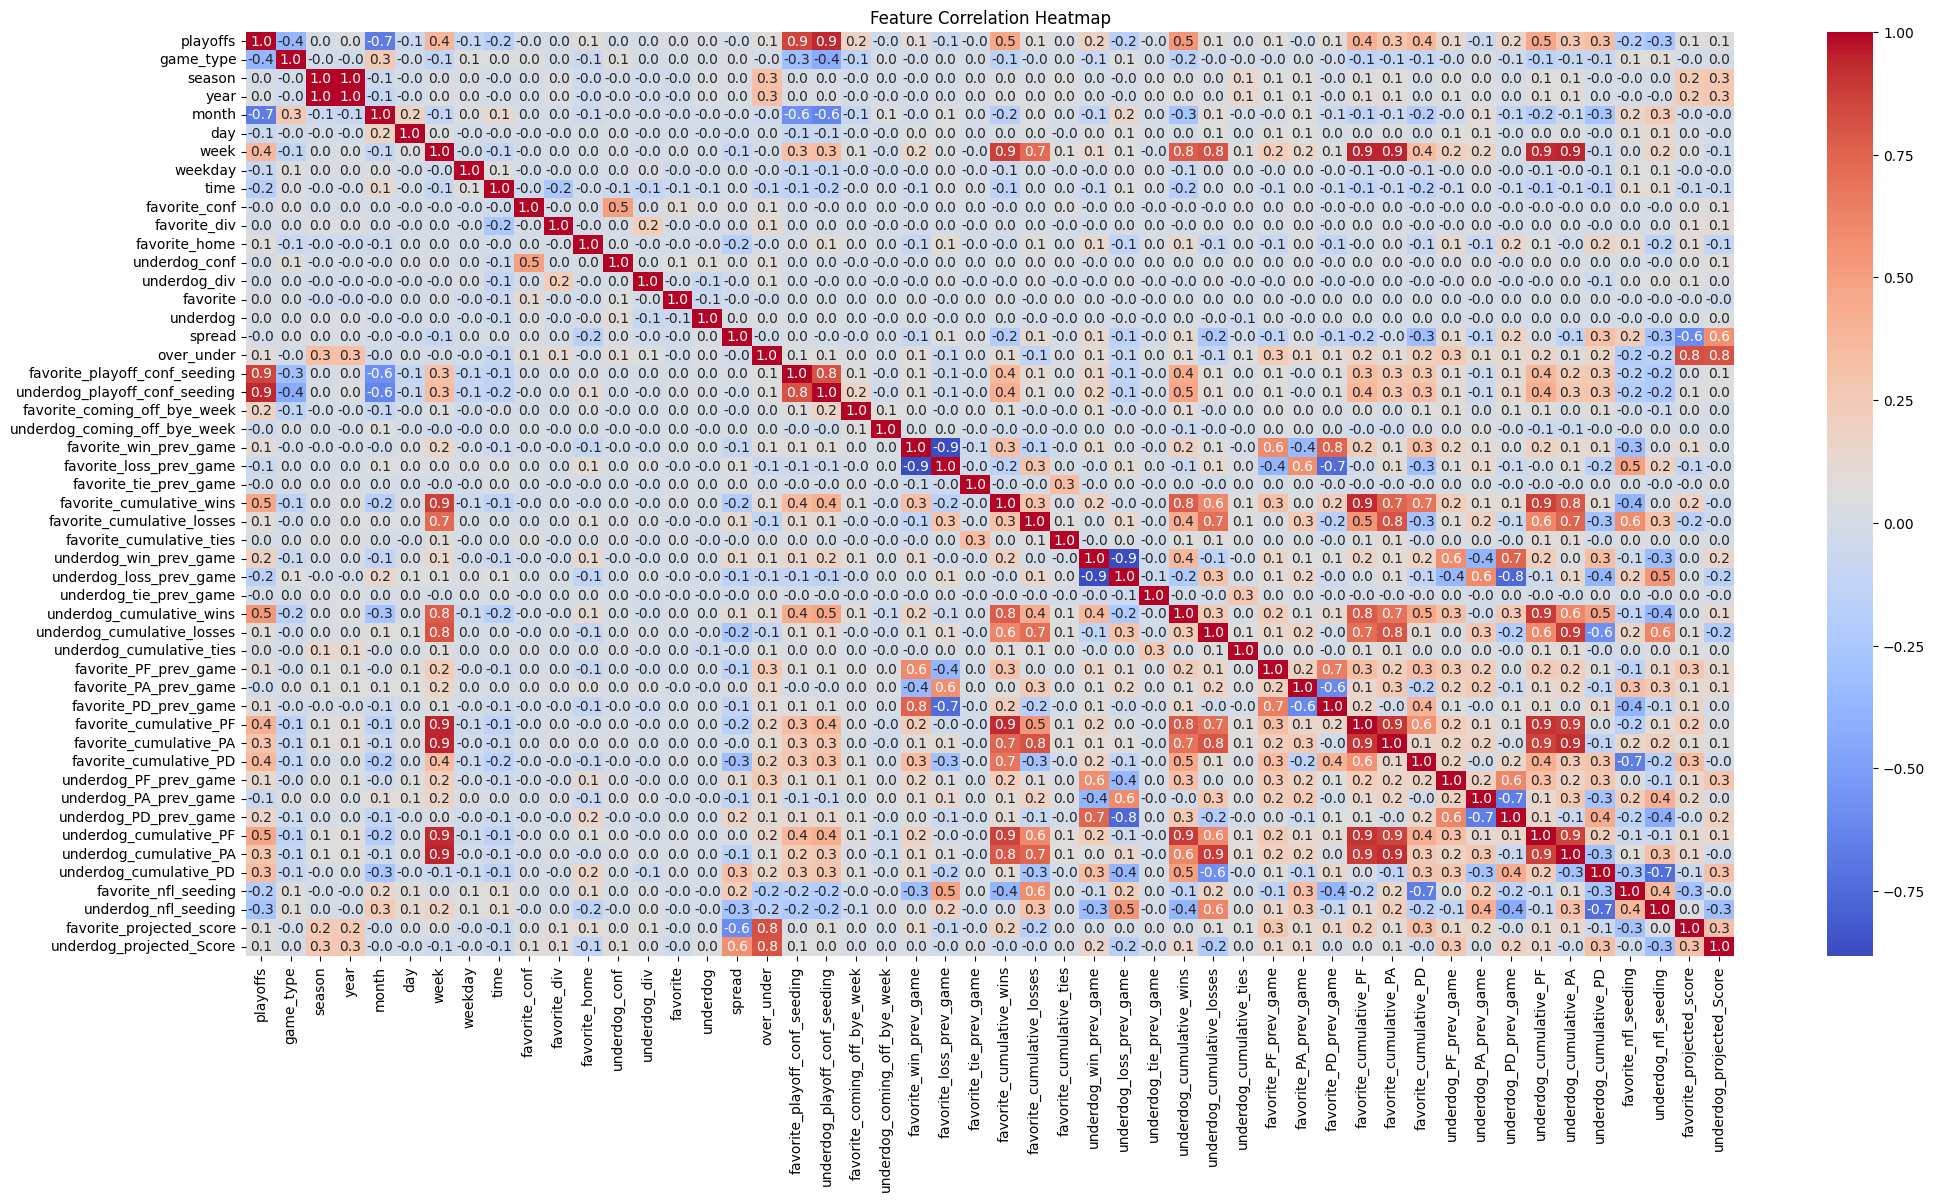

In [ ]:
# Check correlation to features (see if anything is highly corelated to remove in the future)
plt.figure(figsize=(24,12))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
output_columns

['favorite_score',
 'underdog_score',
 'favorite_outright_result',
 'favorite_spread_result',
 'over_under_result']

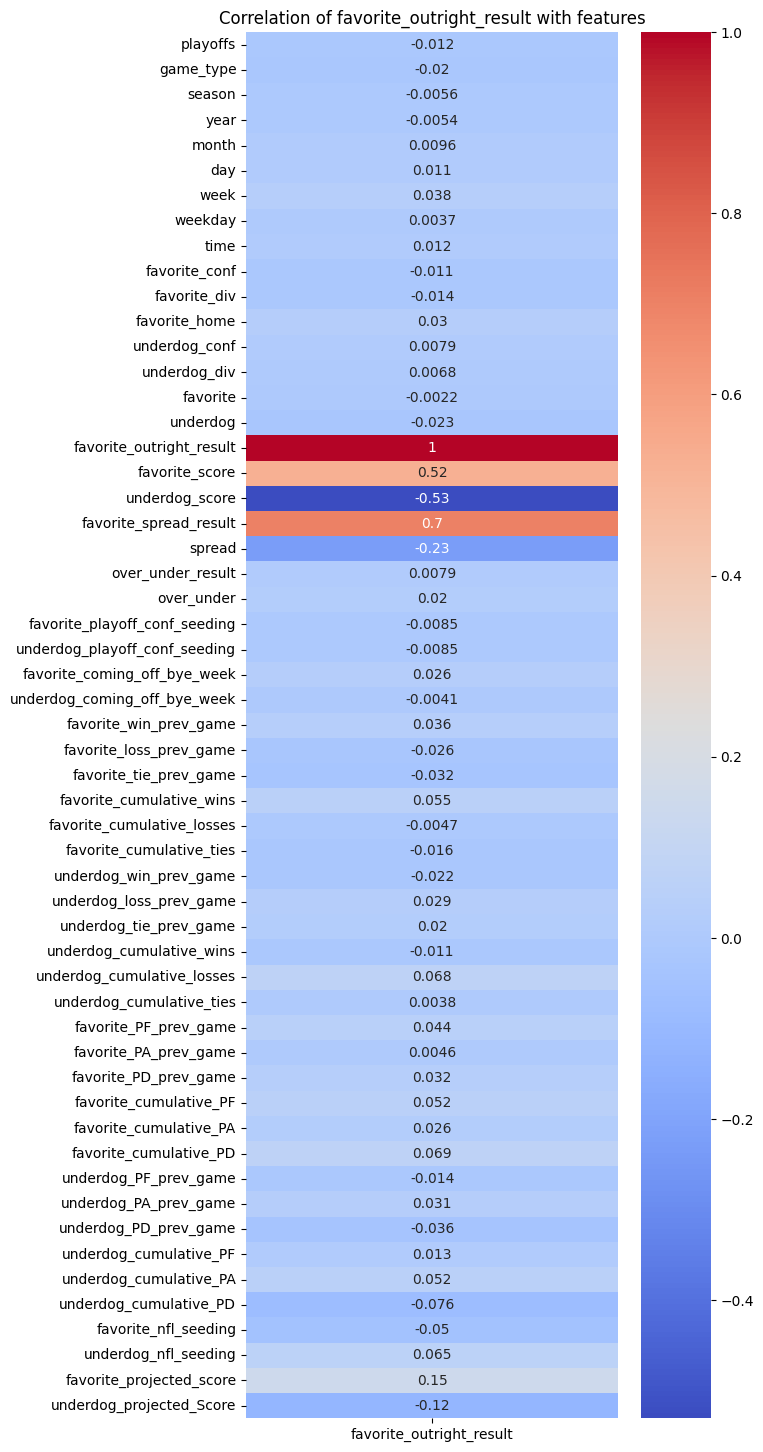

In [ ]:
target_column = 'favorite_outright_result'

# Calculate correlations with the target column
corr = nfl_df.corr()[[target_column]]  # Note the double brackets to keep it a DataFrame

# Plot the correlation as a heatmap
plt.figure(figsize=(6, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)

# Customize the plot
plt.title(f'Correlation of {target_column} with features')
plt.show()

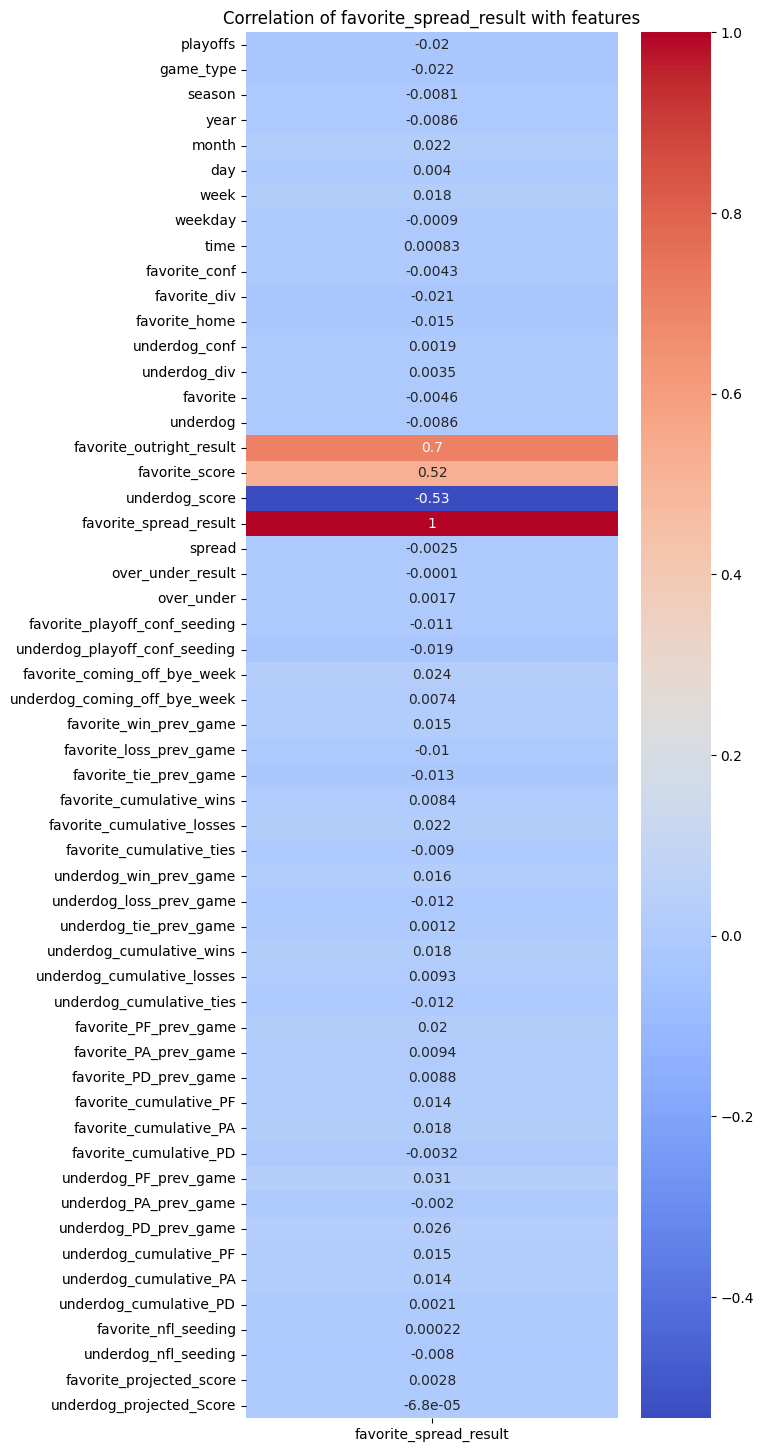

In [ ]:
target_column = 'favorite_spread_result'

# Calculate correlations with the target column
corr = nfl_df.corr()[[target_column]]  # Note the double brackets to keep it a DataFrame

# Plot the correlation as a heatmap
plt.figure(figsize=(6, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)

# Customize the plot
plt.title(f'Correlation of {target_column} with features')
plt.show()

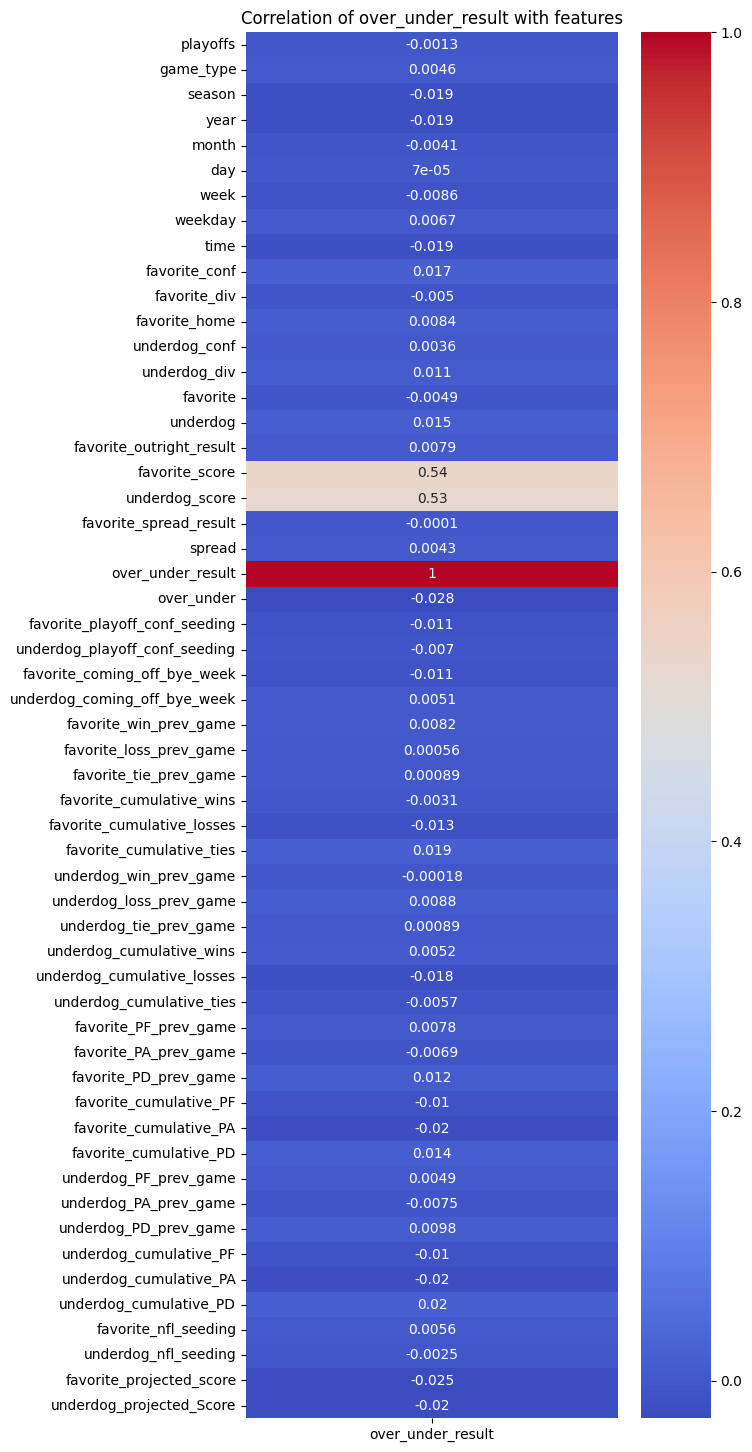

In [ ]:
target_column = 'over_under_result'

# Calculate correlations with the target column
corr = nfl_df.corr()[[target_column]]  # Note the double brackets to keep it a DataFrame

# Plot the correlation as a heatmap
plt.figure(figsize=(6, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)

# Customize the plot
plt.title(f'Correlation of {target_column} with features')
plt.show()

## Bar Plots
* Spread Results
  * Favorite ratio coming off of bye
  * Favorite ratio coming off win
  * Favorite ratio coming off loss

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[nfl_df.favorite_coming_off_bye_week == 1][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()
grouped_df

favorite
favorite_spread_result          
-1                           213
 0                            10
 1                           239

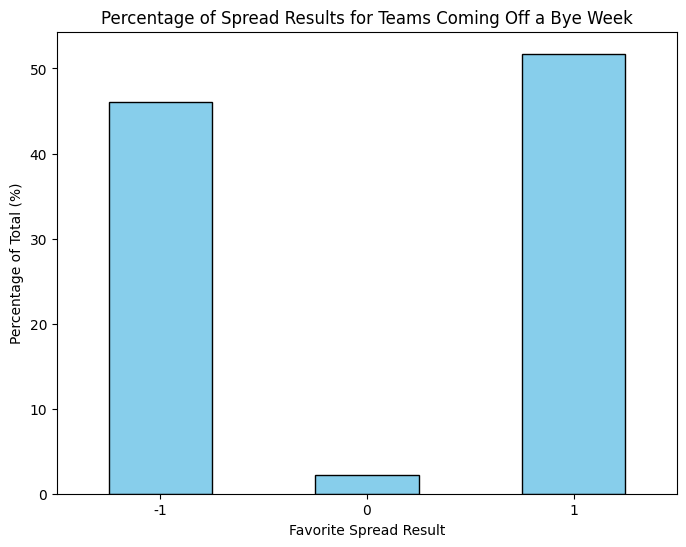

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[nfl_df.favorite_coming_off_bye_week == 1][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Plot the bar chart with percentages
plt.figure(figsize=(8, 6))
grouped_df['percentage'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Percentage of Spread Results for Teams Coming Off a Bye Week')
plt.ylabel('Percentage of Total (%)')
plt.xlabel('Favorite Spread Result')
plt.xticks(rotation=0)

# Show the plot
plt.show()

## Spread Chances (Donut Ratio Charts)

Sample Size: 462


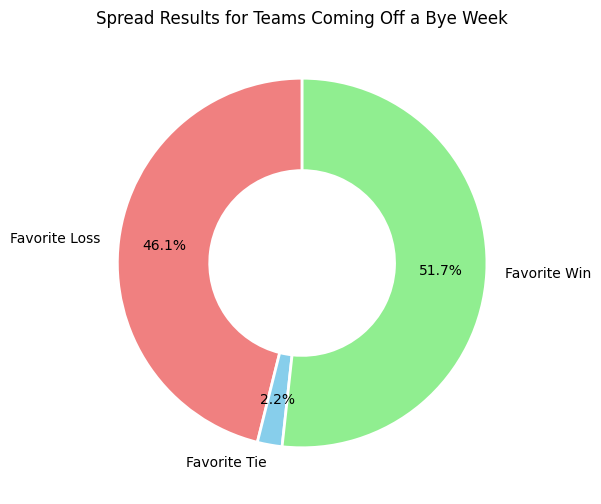

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[nfl_df.favorite_coming_off_bye_week == 1][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)

# Plot the donut chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'], wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for Favorites Coming Off a Bye Week')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

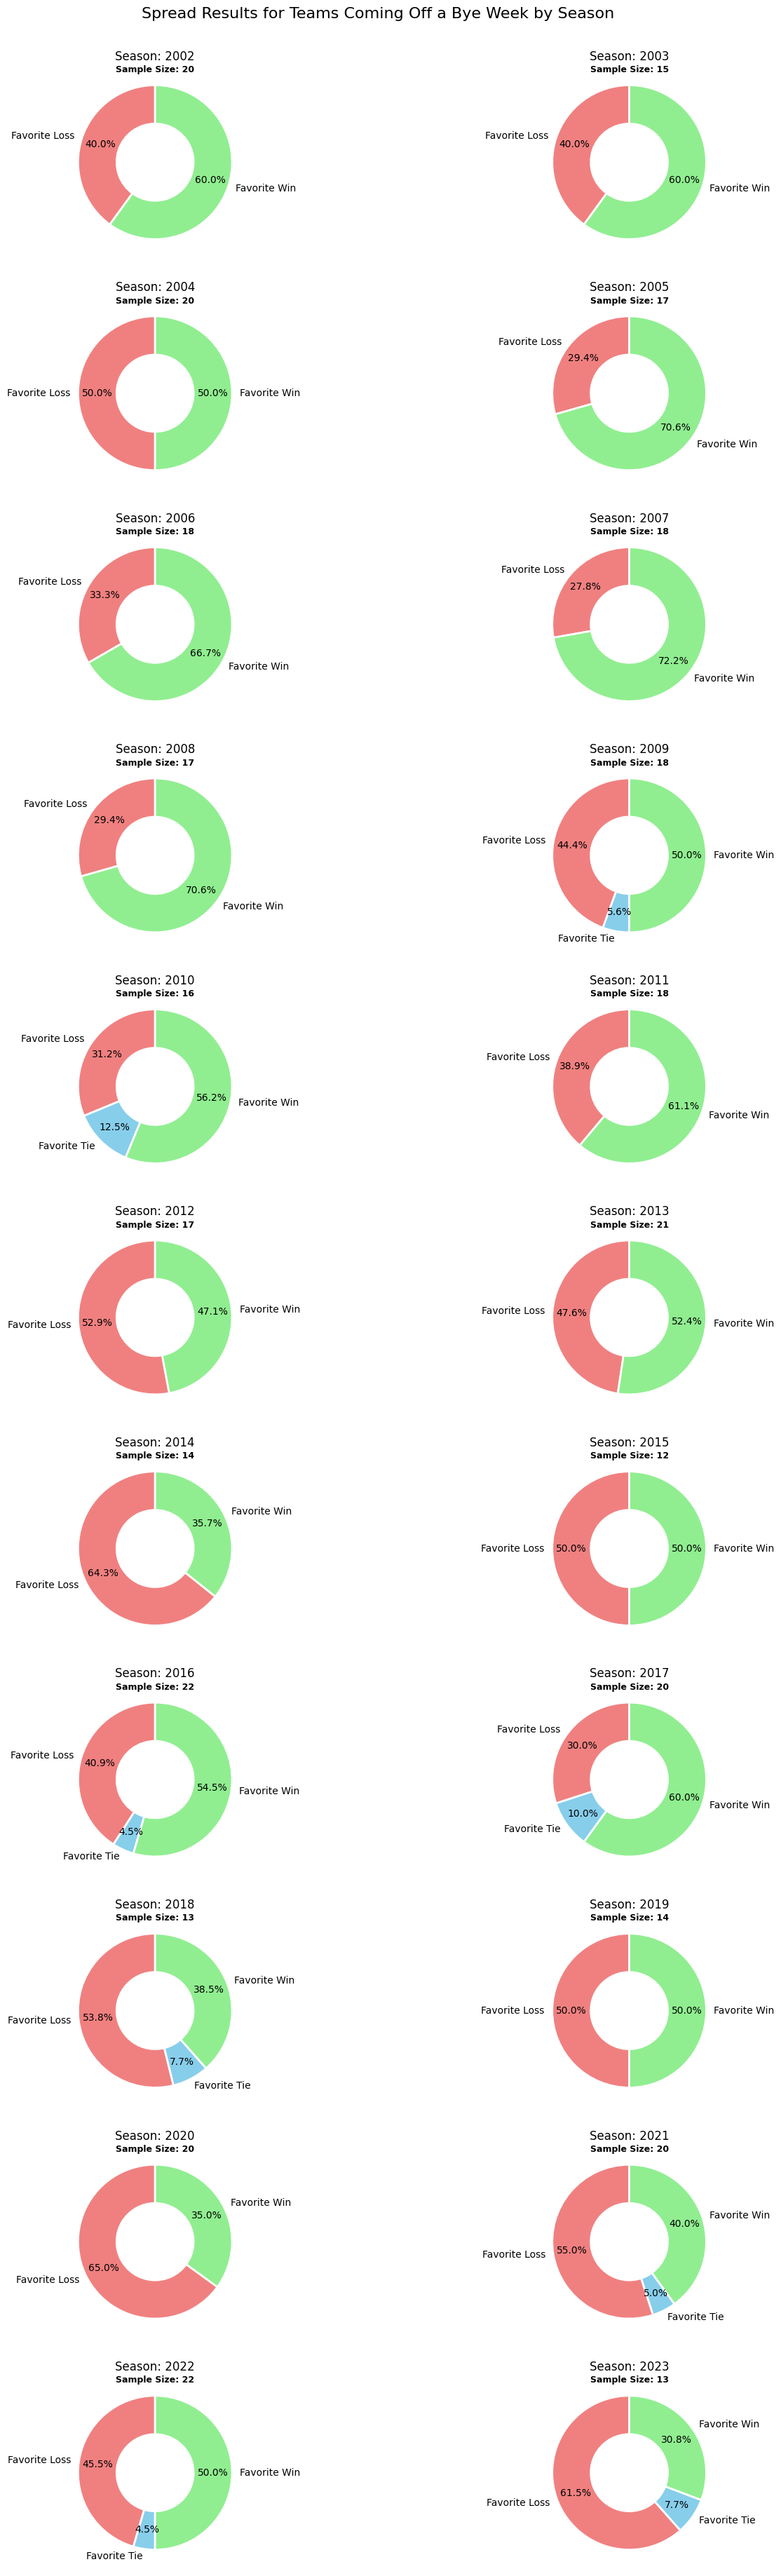

In [ ]:
# # Make charts for each season remove playoffs

# Filter the DataFrame and group by
input_df = nfl_df[(nfl_df.favorite_coming_off_bye_week == 1) & (nfl_df.playoffs == 0)][['season','favorite_spread_result','favorite']].groupby(['season', 'favorite_spread_result']).count()

# Set up the subplots (one subplot for each season)
seasons = nfl_df['season'].unique()
fig, ax = plt.subplots(int(len(seasons)/2), 2, figsize=(16, 42))

i, j = 0, 0  # Initialize indices for subplots

# Generate a donut chart for each season
for season in seasons:

  grouped_df = input_df.loc[pd.IndexSlice[season,:],:].copy()

  # Calculate the percentage of the total
  grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

  # Drop the season portion of the index
  grouped_df = grouped_df.droplevel('season')

  # Map the spread result values to custom labels
  label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
  labels = grouped_df.index.map(label_mapping)

  # Plot the donut chart
  colors = ['lightcoral', 'skyblue', 'lightgreen'] if grouped_df.count()['favorite'] == 3 else ['lightcoral', 'lightgreen']
  ax[i,j].pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

  # Add a title
  ax[i,j].set_title(f'Season: {season}', fontsize = 12)

  sample_size = grouped_df.favorite.sum()
  ax[i,j].text(0, 1.2, f'Sample Size: {sample_size}', ha='center', va='center', fontsize=9, fontweight='bold')

  # Add increment logic
  j += 1
  if j == 2:
    j = 0
    i += 1

# Adjust layout and display the plot
fig.suptitle('Spread Results for Favorites Coming Off a Bye Week by Season', fontsize=16)
plt.subplots_adjust(top=0.96)
plt.show()

Sample Size: 321


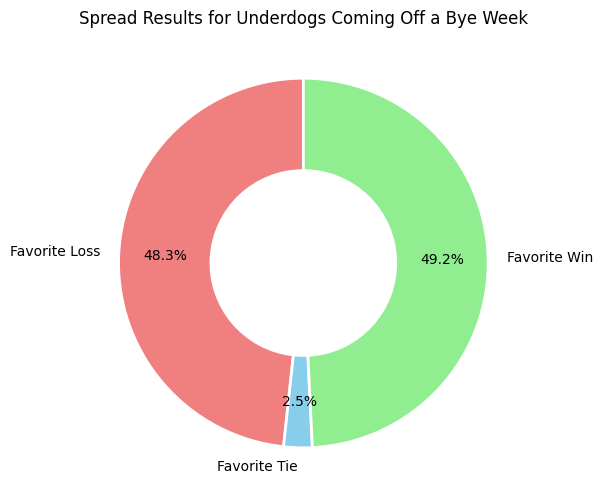

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[(nfl_df.underdog_coming_off_bye_week == 1) & (nfl_df.playoffs == 0)][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)

# Plot the donut chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'], wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for Underdogs Coming Off a Bye Week')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

Sample Size: 3118


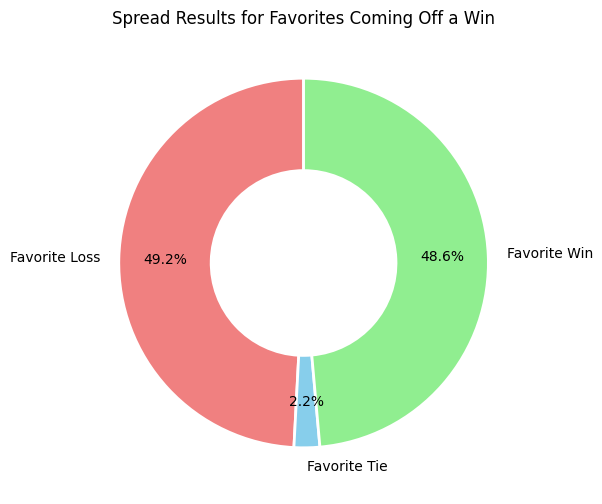

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[(nfl_df.favorite_win_prev_game == 1) & (nfl_df.playoffs == 0)][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)

# Plot the donut chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'], wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for Favorites Coming Off a Win')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

Sample Size: 2195


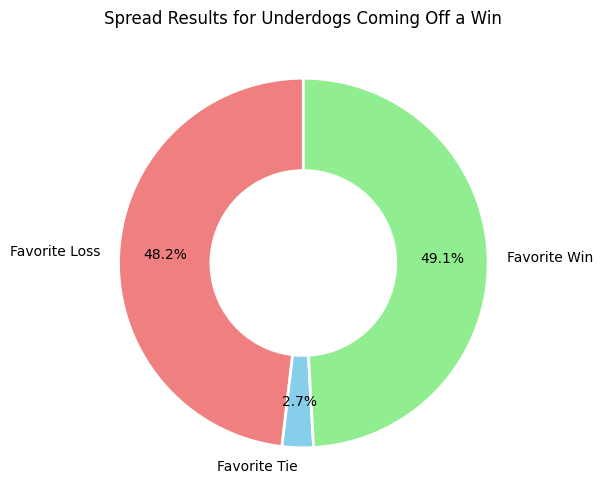

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[(nfl_df.underdog_win_prev_game == 1) & (nfl_df.playoffs == 0)][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)

# Plot the donut chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'], wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for Underdogs Coming Off a Win')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

Sample Size: 145


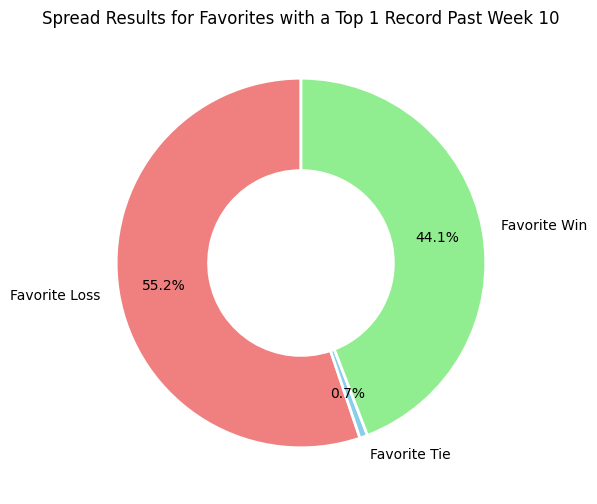

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[(nfl_df.favorite_nfl_seeding <= 1) & (nfl_df.playoffs == 0) & (nfl_df.week >= 10)][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)


# Plot the donut chart
plt.figure(figsize=(8, 6))
colors = ['lightcoral', 'skyblue', 'lightgreen'] if grouped_df.count()['favorite'] == 3 else ['lightcoral', 'lightgreen']
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for Favorites with a Top 1 Record Past Week 10')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

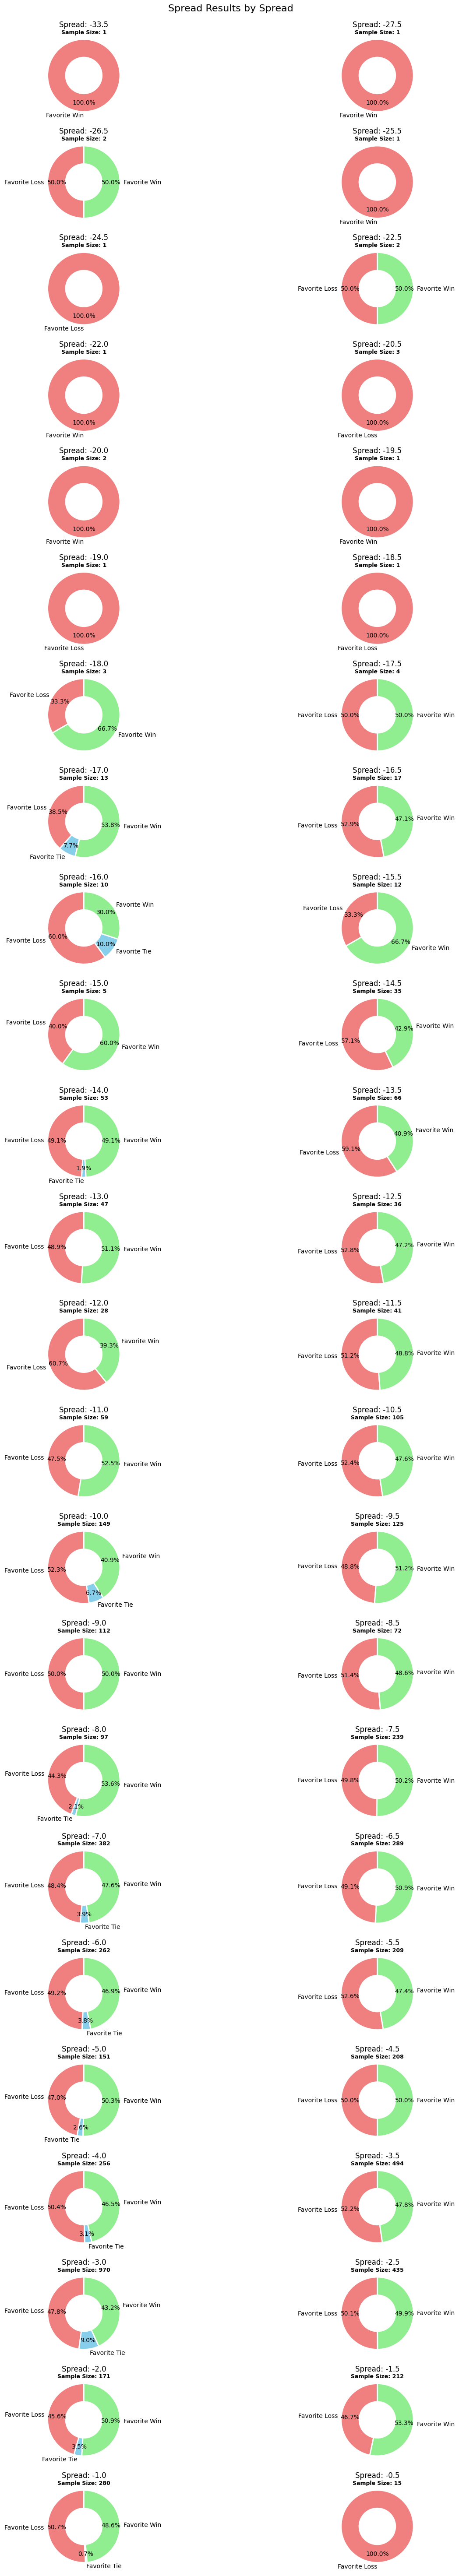

In [ ]:
# # Make charts for each season remove playoffs

# Filter the DataFrame and group by
input_df = nfl_df[(nfl_df.playoffs == 0)][['spread','favorite_spread_result','favorite']].groupby(['spread', 'favorite_spread_result']).count()

# Set up the subplots (one subplot for each season)
spreads = input_df.index.get_level_values(0).unique()
fig, ax = plt.subplots(int(len(spreads)/2), 2, figsize=(16, 60))

i, j = 0, 0  # Initialize indices for subplots

# Generate a donut chart for each season
for spread in spreads:

  grouped_df = input_df.loc[pd.IndexSlice[spread,:],:].copy()

  # Calculate the percentage of the total
  grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

  # Drop the season portion of the index
  grouped_df = grouped_df.droplevel('spread')

  # Map the spread result values to custom labels
  label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
  labels = grouped_df.index.map(label_mapping)

  # Plot the donut chart
  colors = ['lightcoral', 'skyblue', 'lightgreen'] if grouped_df.count()['favorite'] == 3 else ['lightcoral', 'lightgreen']
  ax[i,j].pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

  # Add a title
  ax[i,j].set_title(f'Spread: {spread}', fontsize = 12)

  sample_size = grouped_df.favorite.sum()
  ax[i,j].text(0, 1.2, f'Sample Size: {sample_size}', ha='center', va='center', fontsize=9, fontweight='bold')

  # Add increment logic
  j += 1
  if j == 2:
    j = 0
    i += 1

# Adjust layout and display the plot
fig.suptitle('Spread Results by Spread', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=.97)
plt.show()

In [ ]:
nfl_df[nfl_df.spread==-0.5]

playoffs       game_type  season  year  month  day  week weekday  \
29           0  Regular Season    2002  2002      9   15     2     Sun   
364          0  Regular Season    2003  2003     10   19     7     Sun   
595          0  Regular Season    2004  2004     10   10     5     Sun   
696          0  Regular Season    2004  2004     11   28    12     Sun   
766          0  Regular Season    2004  2004     12   26    16     Sun   
878          0  Regular Season    2005  2005     10   16     6     Sun   
884          0  Regular Season    2005  2005     10   16     6     Sun   
925          0  Regular Season    2005  2005     11    6     9     Sun   
1249         0  Regular Season    2006  2006     12    3    13     Sun   
1256         0  Regular Season    2006  2006     12    3    13     Sun   
2380         0  Regular Season    2010  2011      1    2    17     Sun   
2760         0  Regular Season    2012  2012     10   15     6     Mon   
3384         0  Regular Season    2014  2014     11   30    13     Sun   
3455         0  Regular Season    2014  2014     12   28    17     Sun   
4203         0  Regular Season    2017  2017     12   10    14     Sun   

           time favorite_conf favorite_div  favorite_home underdog_conf  \
29      morning           AFC        South              1           AFC   
364     morning           NFC        South              1           AFC   
595     evening           NFC         East              1           AFC   
696   afternoon           NFC         West              1           AFC   
766   afternoon           AFC         East              1           AFC   
878   afternoon           AFC         West              1           AFC   
884     morning           NFC        North              1           NFC   
925     morning           NFC        South              1           NFC   
1249  afternoon           AFC         East              1           AFC   
1256    morning           NFC        North              1           AFC   
2380  afternoon           NFC         East              1           NFC   
2760    evening           AFC         West              1           AFC   
3384    evening           AFC         West              1           AFC   
3455    morning           NFC         East              1           NFC   
4203    morning           NFC        South              1           NFC   

     underdog_div               favorite              underdog  \
29           East     Indianapolis Colts        Miami Dolphins   
364         South      Carolina Panthers      Tennessee Titans   
595         North  Washington Commanders      Baltimore Ravens   
696          East    San Francisco 49ers        Miami Dolphins   
766          East          New York Jets  New England Patriots   
878          West      Las Vegas Raiders  Los Angeles Chargers   
884         South          Detroit Lions     Carolina Panthers   
925         South   Tampa Bay Buccaneers     Carolina Panthers   
1249        South         Miami Dolphins  Jacksonville Jaguars   
1256         East      Green Bay Packers         New York Jets   
2380         East    Philadelphia Eagles        Dallas Cowboys   
2760         West   Los Angeles Chargers        Denver Broncos   
3384         West     Kansas City Chiefs        Denver Broncos   
3455         East        New York Giants   Philadelphia Eagles   
4203        North   Tampa Bay Buccaneers         Detroit Lions   

      favorite_outright_result  favorite_score  underdog_score  \
29                          -1              13              21   
364                         -1              17              37   
595                         -1              10              17   
696                         -1              17              24   
766                         -1               7              23   
878                         -1              14              27   
884                         -1              20              21   
925                         -1     

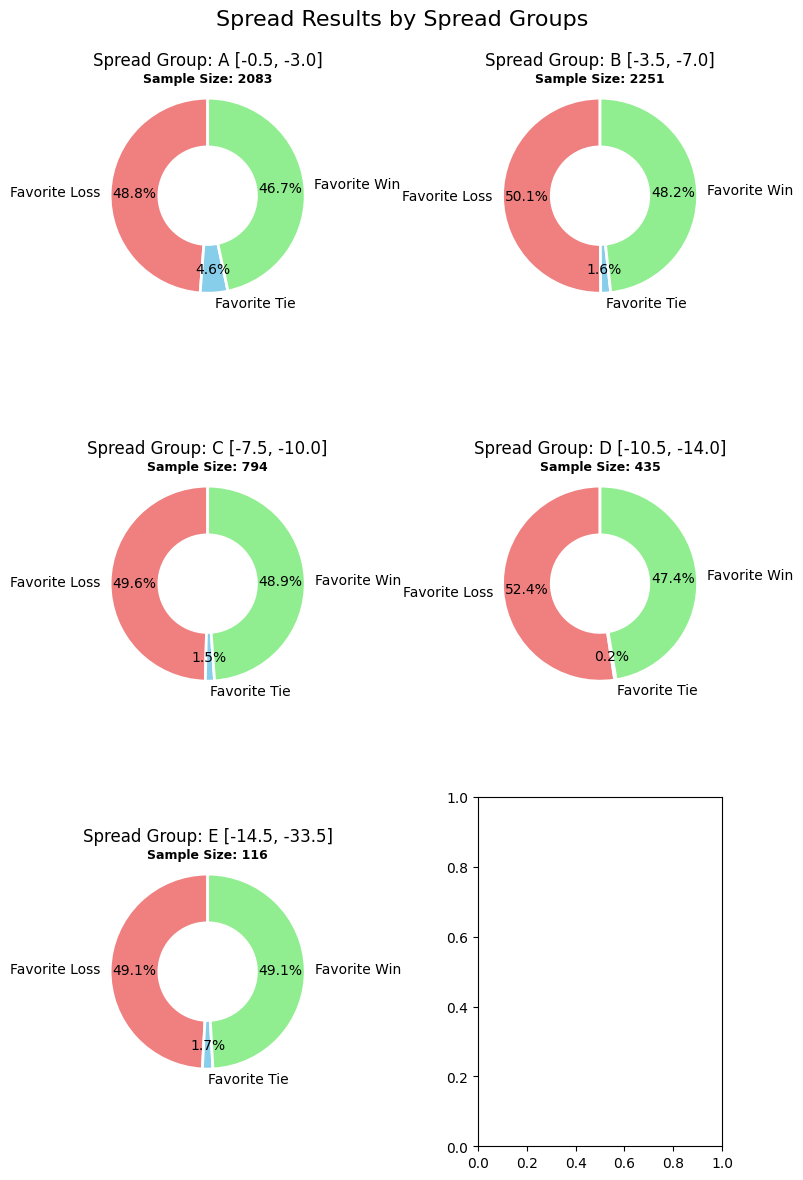

In [ ]:
# # Make charts for each season remove playoffs

# Filter the DataFrame and group by
input_df = nfl_df.copy()
input_df['Spread Group'] = input_df['spread'].abs().apply(lambda x: 'A [-0.5, -3.0]' if 0.5 <= x <= 3 else
                                                    'B [-3.5, -7.0]' if 3.5 <= x <= 7 else
                                                    'C [-7.5, -10.0]' if 7.5 <= x <= 10 else
                                                    'D [-10.5, -14.0]' if 10.5 <= x <= 14 else
                                                    'E [-14.5, ' + str(min(input_df['spread'])) + ']')

input_df = input_df[(input_df.playoffs == 0)][['Spread Group','favorite_spread_result','favorite']].groupby(['Spread Group', 'favorite_spread_result']).count()

# Set up the subplots (one subplot for each season)
spreads = input_df.index.get_level_values(0).unique()
fig, ax = plt.subplots(math.ceil(len(spreads)/2), 2, figsize=(8, 12))

i, j = 0, 0  # Initialize indices for subplots

# Generate a donut chart for each season
for spread in spreads:

  grouped_df = input_df.loc[pd.IndexSlice[spread,:],:].copy()

  # Calculate the percentage of the total
  grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

  # Drop the season portion of the index
  grouped_df = grouped_df.droplevel('Spread Group')

  # Map the spread result values to custom labels
  label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
  labels = grouped_df.index.map(label_mapping)

  # Plot the donut chart
  colors = ['lightcoral', 'skyblue', 'lightgreen'] if grouped_df.count()['favorite'] == 3 else ['lightcoral', 'lightgreen']

  ax[i,j].pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

  # Add a title
  ax[i,j].set_title(f'Spread Group: {spread}', fontsize = 12)

  sample_size = grouped_df.favorite.sum()
  ax[i,j].text(0, 1.2, f'Sample Size: {sample_size}', ha='center', va='center', fontsize=9, fontweight='bold')


  # Add increment logic
  j += 1
  if j == 2:
    j = 0
    i += 1

# Adjust layout and display the plot
fig.suptitle('Spread Results by Spread Groups', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=.97)
plt.show()

Sample Size: 14


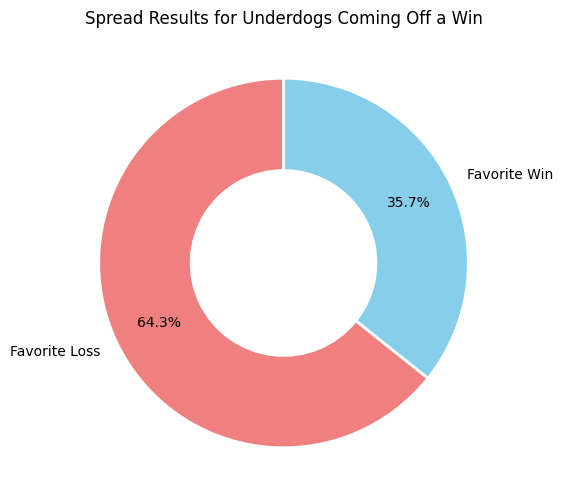

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[(nfl_df.favorite_tie_prev_game == 1) & (nfl_df.playoffs == 0)][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)

# Plot the donut chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'], wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for Favorites Coming Off a Tie')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

Sample Size: 20


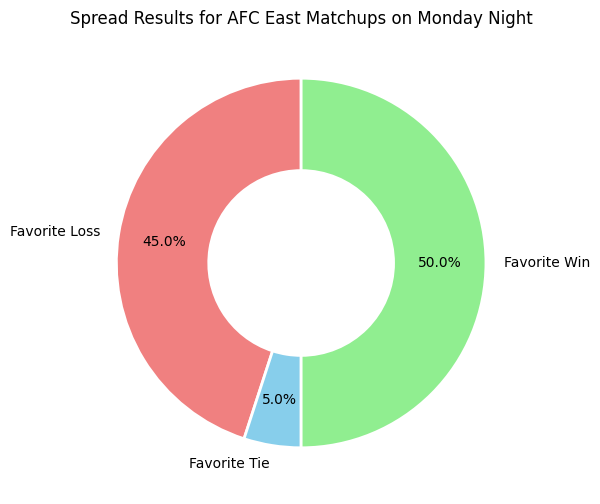

In [ ]:
# Filter the DataFrame and group by
grouped_df = nfl_df[(nfl_df.weekday == 'Mon') & (nfl_df.favorite_conf == 'AFC') & (nfl_df.favorite_div == 'East') & (nfl_df.underdog_conf == 'AFC') & (nfl_df.underdog_div == 'East') & (nfl_df.playoffs == 0)][['favorite_spread_result','favorite']].groupby('favorite_spread_result').count()

# Calculate the percentage of the total
grouped_df['percentage'] = (grouped_df['favorite'] / grouped_df['favorite'].sum()) * 100

# Map the spread result values to custom labels
label_mapping = {-1: 'Favorite Loss', 1: 'Favorite Win', 0: 'Favorite Tie'}
labels = grouped_df.index.map(label_mapping)

# Plot the donut chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df['percentage'], labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'], wedgeprops={'width': .5, 'linewidth':2, 'edgecolor': 'white'}, pctdistance=.75)

# Add a title
plt.title('Spread Results for AFC East Matchups on Monday Night')

# Display the chart
print(f'Sample Size: {grouped_df.favorite.sum()}')
plt.show()

In [ ]:
math.ceil(len(spreads)/2)

3

In [ ]:
print('Most Common Spreads: ')
nfl_df.groupby('spread').count().sort_values(by='favorite', ascending=False)['favorite'].reset_index().rename(columns={'spread':'Spread','favorite':'Spread Count'}).head(10)

Most Common Spreads: 


Spread  Spread Count
0    -3.0          1011
1    -3.5           512
2    -2.5           455
3    -7.0           400
4    -6.5           303
5    -1.0           287
6    -4.0           273
7    -6.0           273
8    -7.5           255
9    -4.5           218

In [ ]:
abs(min(input_df['spread']))

33.5

In [ ]:
input_df = nfl_df.copy()
input_df['Spread Group'] = input_df['spread'].abs().apply(lambda x: [-0.5, -3.0] if 0.5 <= x <= 3 else
                                                    [-3.5, -7.0] if 3.5 <= x <= 7 else
                                                    [-7.5, -10.0] if 7.5 <= x <= 10 else
                                                    [-10.5, -14.0] if 10.5 <= x <= 14 else
                                                    [-14.5, min(input_df['spread'])])
input_df[['spread','Spread Group']].head(20)

spread    Spread Group
0     -4.0    [-3.5, -7.0]
1     -8.5   [-7.5, -10.0]
2     -7.5   [-7.5, -10.0]
3     -3.0    [-0.5, -3.0]
4     -2.0    [-0.5, -3.0]
5     -6.0    [-3.5, -7.0]
6     -9.5   [-7.5, -10.0]
7     -6.0    [-3.5, -7.0]
8     -7.0    [-3.5, -7.0]
9     -2.0    [-0.5, -3.0]
10    -3.0    [-0.5, -3.0]
11    -4.5    [-3.5, -7.0]
12    -2.5    [-0.5, -3.0]
13    -3.0    [-0.5, -3.0]
14    -3.5    [-3.5, -7.0]
15    -2.5    [-0.5, -3.0]
16   -12.0  [-10.5, -14.0]
17    -4.0    [-3.5, -7.0]
18   -13.5  [-10.5, -14.0]
19    -3.5    [-3.5, -7.0]

In [ ]:
input_df = nfl_df.copy()
input_df['Spread Group'] = pd.cut(input_df['spread'], bins=10)
input_df

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
grouped_df.droplevel('year')

favorite  percentage
favorite_spread_result                      
-1                             8   53.333333
 0                             1    6.666667
 1                             6   40.000000

In [ ]:
grouped_df.loc[pd.IndexSlice[2023,:],:]

favorite  percentage
year favorite_spread_result                      
2023 -1                             8    2.077922
      0                             1    0.259740
      1                             6    1.558442

## Favorite Win Weekly Analysis

In [ ]:
nfl_df.columns

Index(['playoffs', 'game_type', 'season', 'year', 'month', 'day', 'week',
       'weekday', 'time', 'favorite_conf', 'favorite_div', 'favorite_home',
       'underdog_conf', 'underdog_div', 'favorite', 'underdog',
       'favorite_outright_result', 'favorite_score', 'underdog_score',
       'favorite_spread_result', 'spread', 'over_under_result', 'over_under',
       'favorite_playoff_conf_seeding', 'underdog_playoff_conf_seeding',
       'favorite_coming_off_bye_week', 'underdog_coming_off_bye_week',
       'favorite_win_prev_game', 'favorite_loss_prev_game',
       'favorite_tie_prev_game', 'favorite_cumulative_wins',
       'favorite_cumulative_losses', 'favorite_cumulative_ties',
       'underdog_win_prev_game', 'underdog_loss_prev_game',
       'underdog_tie_prev_game', 'underdog_cumulative_wins',
       'underdog_cumulative_losses', 'underdog_cumulative_ties',
       'favorite_PF_prev_game', 'favorite_PA_prev_game',
       'favorite_PD_prev_game', 'favorite_cumulative_PF',
      

In [ ]:
nfl_df.game_type.unique()

array(['Regular Season', 'NFC Wild Card', 'AFC Wild Card',
       'AFC Divisional', 'NFC Divisional', 'AFC Championship',
       'NFC Championship', 'Super Bowl XXXVII', 'Super Bowl XXXVIII',
       'Super Bowl XXXIX', 'Super Bowl XL', 'Super Bowl XLI',
       'Super Bowl XLII', 'Super Bowl XLIII', 'Super Bowl XLIV',
       'Super Bowl XLV', 'Super Bowl XLVI', 'Super Bowl XLVII',
       'Super Bowl XLVIII', 'Super Bowl XLIX', 'Super Bowl 50',
       'Super Bowl LI', 'Super Bowl LII', 'Super Bowl LIII',
       'Super Bowl LIV', 'Super Bowl LV', 'Super Bowl LVI',
       'Super Bowl LVII', 'Super Bowl LVIII'], dtype=object)

In [ ]:
spread_odds.head()

point_spread  fav_win_pct fav_ml  fav_return  dog_win_pct  dog_ml  \
0           0.0         0.50   -100    2.000000         0.50     100   
1          -0.5         0.50   -100    2.000000         0.50     100   
2          -1.0         0.51   -105    1.952381         0.49     105   
3          -1.5         0.53   -111    1.900901         0.48     111   
4          -2.0         0.54   -115    1.869565         0.47     115   

   dog_return  
0        2.00  
1        2.00  
2        2.05  
3        2.11  
4        2.15

In [ ]:
# Create Sub df to determine each weeks output in terms of total favorite wins and win %

def create_aggregate_df(df):

  tmp = df.copy()

  # filter out playoff weeks
  tmp = tmp[tmp.playoffs == 0]

  # Convert -1 to 0 in favorite win column to prep for fav win sum
  tmp['favorite_outright_result'] = tmp['favorite_outright_result'].apply(lambda x : 0 if x == -1 else 1)

  favorite_weekly_wins = tmp.groupby(['season','week']).agg({'favorite': 'count',
                                                              'favorite_outright_result':'sum'})

  favorite_weekly_wins.rename(columns={'favorite':'games_played','favorite_outright_result':'favorite_wins'}, inplace=True)

  favorite_weekly_wins['favorite_losses'] = favorite_weekly_wins.games_played - favorite_weekly_wins.favorite_wins

  favorite_weekly_wins['win_pct'] = favorite_weekly_wins.favorite_wins / favorite_weekly_wins.games_played

  return favorite_weekly_wins

In [ ]:
nfl_weekly_wins = create_aggregate_df(nfl_df).reset_index()
nfl_weekly_wins[(nfl_weekly_wins.season == 2023)]

season  week  games_played  favorite_wins  favorite_losses   win_pct
359    2023     1            16              8                8  0.500000
360    2023     2            16             10                6  0.625000
361    2023     3            16             11                5  0.687500
362    2023     4            16             13                3  0.812500
363    2023     5            14              8                6  0.571429
364    2023     6            15             11                4  0.733333
365    2023     7            13              6                7  0.461538
366    2023     8            16             12                4  0.750000
367    2023     9            14             12                2  0.857143
368    2023    10            14              8                6  0.571429
369    2023    11            14             11                3  0.785714
370    2023    12            16             12                4  0.750000
371    2023    13            13             10                3  0.769231
372    2023    14            15              7                8  0.466667
373    2023    15            16             12                4  0.750000
374    2023    16            16             11                5  0.687500
375    2023    17            16             12                4  0.750000
376    2023    18            16             11                5  0.687500

In [ ]:
game_counts = nfl_weekly_wins.games_played.unique()
game_counts.sort()
game_counts

array([13, 14, 15, 16])

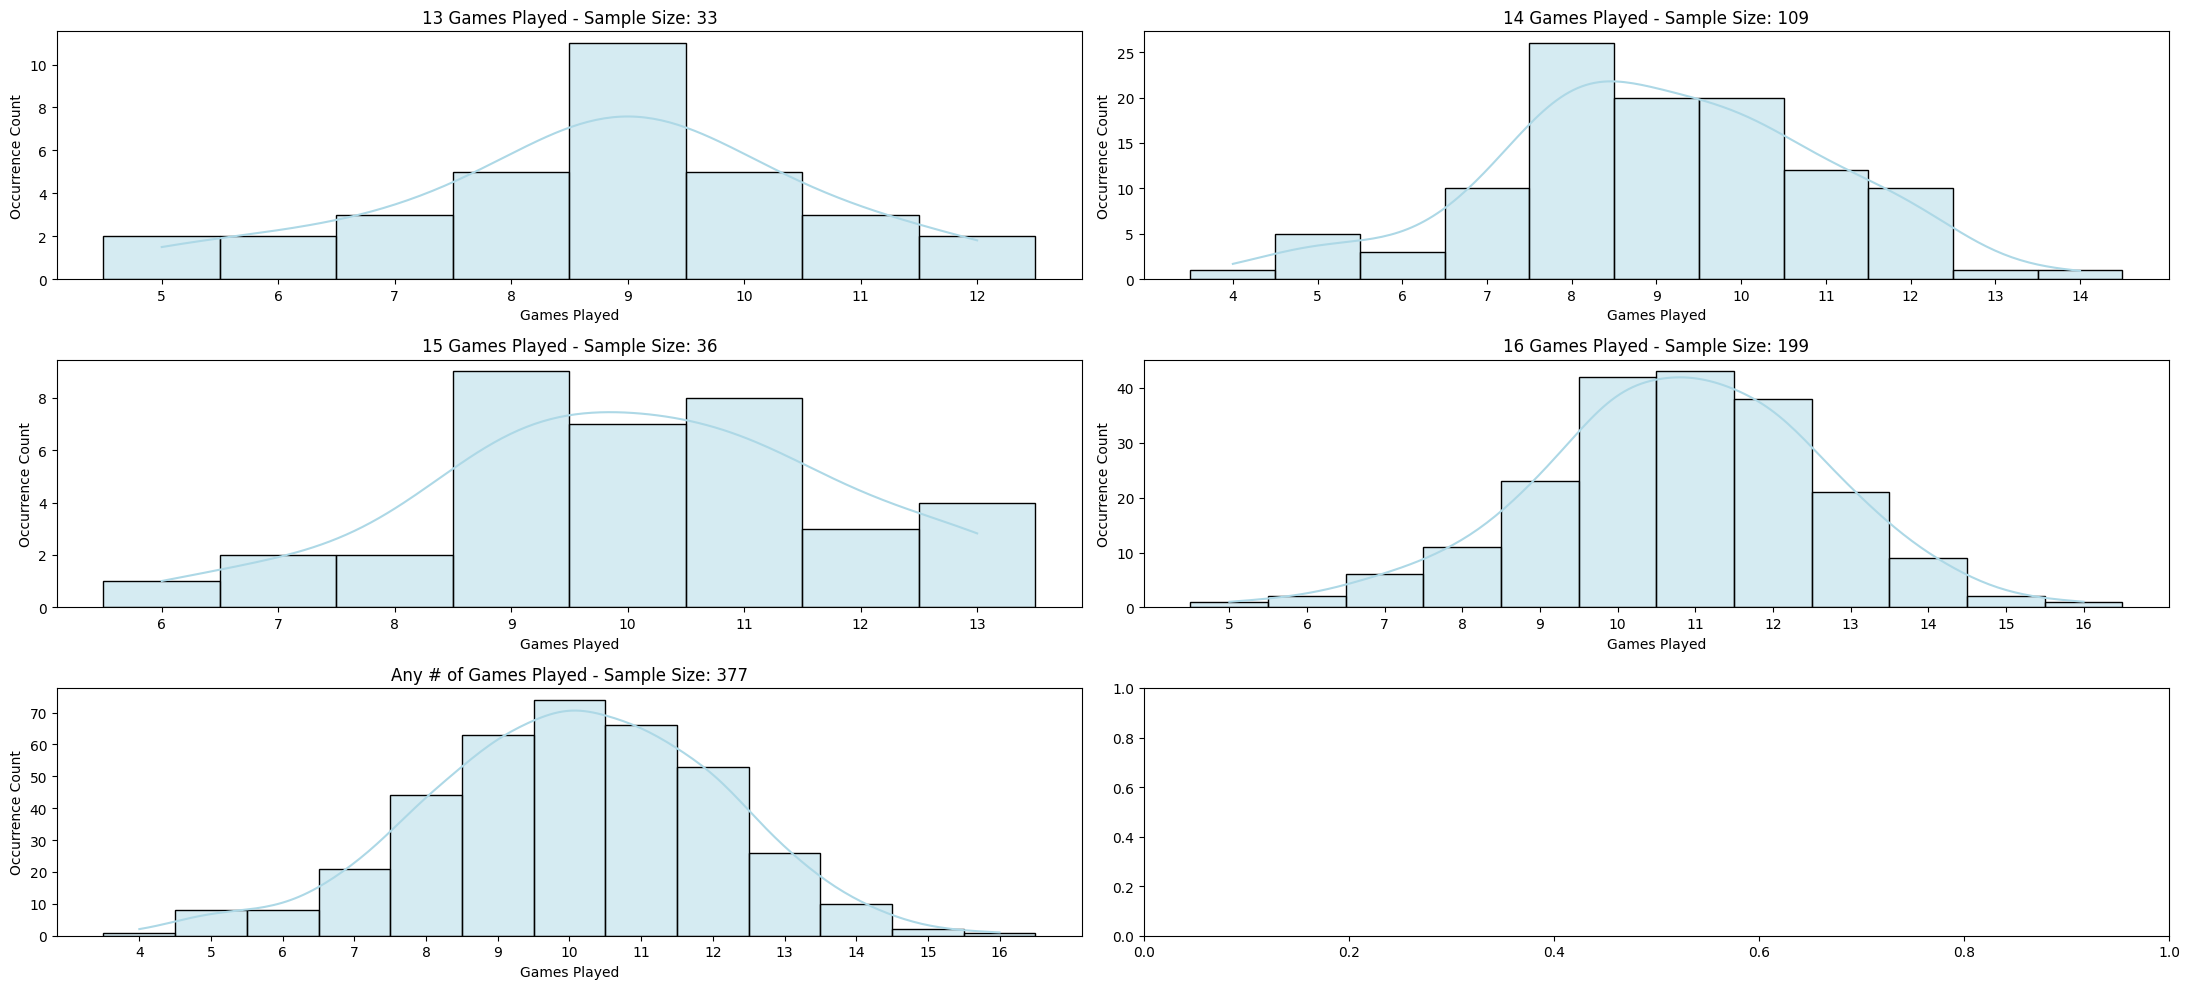

In [ ]:
# Create histograms for each amount of games played in a given week

fig, ax = plt.subplots(3, 2, figsize=(22, 10))

data = nfl_weekly_wins[nfl_weekly_wins.games_played == 13]['favorite_wins']
bins = len(data.unique())
ss = data.count()
x_ticks = data.unique()

sns.histplot(data, kde=True, color='lightblue', bins = bins, fill = True, discrete= True, ax = ax[0,0])
ax[0,0].set_xticks(x_ticks);
ax[0,0].set_title(f'13 Games Played - Sample Size: {ss}')
ax[0,0].set_xlabel('Games Played')
ax[0,0].set_ylabel('Occurrence Count');

#--------------------------------------------------------------------------#

data = nfl_weekly_wins[nfl_weekly_wins.games_played == 14]['favorite_wins']
bins = len(data.unique())
ss = data.count()
x_ticks = data.unique()

sns.histplot(data, kde=True, color='lightblue', bins = bins, discrete= True, ax = ax[0,1])
ax[0,1].set_xticks(x_ticks);
ax[0,1].set_title(f'14 Games Played - Sample Size: {ss}')
ax[0,1].set_xlabel('Games Played')
ax[0,1].set_ylabel('Occurrence Count')

#--------------------------------------------------------------------------#

data = nfl_weekly_wins[nfl_weekly_wins.games_played == 15]['favorite_wins']
bins = len(data.unique())
ss = data.count()
x_ticks = data.unique()

sns.histplot(data, kde=True, color='lightblue', bins = bins, discrete= True, ax = ax[1,0])
ax[1,0].set_xticks(x_ticks);
ax[1,0].set_title(f'15 Games Played - Sample Size: {ss}')
ax[1,0].set_xlabel('Games Played')
ax[1,0].set_ylabel('Occurrence Count')

#--------------------------------------------------------------------------#

data = nfl_weekly_wins[nfl_weekly_wins.games_played == 16]['favorite_wins']
bins = len(data.unique())
ss = data.count()
x_ticks = data.unique()

sns.histplot(data, kde=True, color='lightblue', bins = bins, discrete= True, ax = ax[1,1])
ax[1,1].set_xticks(x_ticks);
ax[1,1].set_title(f'16 Games Played - Sample Size: {ss}')
ax[1,1].set_xlabel('Games Played')
ax[1,1].set_ylabel('Occurrence Count')

#--------------------------------------------------------------------------#

data = nfl_weekly_wins['favorite_wins']
bins = len(data.unique())
ss = data.count()
x_ticks = data.unique()

sns.histplot(data, kde=True, color='lightblue', bins = bins, discrete= True, ax = ax[2,0])
ax[2,0].set_xticks(x_ticks);
ax[2,0].set_title(f'Any # of Games Played - Sample Size: {ss}')
ax[2,0].set_xlabel('Games Played')
ax[2,0].set_ylabel('Occurrence Count');

plt.tight_layout()


In [ ]:
fav_win_pct_df_by_gp = nfl_weekly_wins.groupby(['games_played','win_pct','favorite_wins']).count()['season'].reset_index().rename(columns={'season':'occurence_count'}).sort_values(by=['games_played','occurence_count'], ascending=[True, False])
fav_win_pct_df_tot = nfl_weekly_wins.groupby(['win_pct']).count()['season'].reset_index().rename(columns={'season':'occurence_count'}).sort_values(by=['occurence_count'], ascending=[False])

In [ ]:
# Get probability rates for each win percentage on given games played

# Initialize probability column
fav_win_pct_df_by_gp['probability'] = 0.0

for gc in game_counts:
  mask = fav_win_pct_df_by_gp['games_played'] == gc
  total_occurrences = fav_win_pct_df_by_gp.loc[mask, 'occurence_count'].sum()
  fav_win_pct_df_by_gp.loc[mask, 'probability'] = fav_win_pct_df_by_gp.loc[mask, 'occurence_count'] / total_occurrences

In [ ]:
fav_win_pct_df_by_gp[fav_win_pct_df_by_gp.games_played == 16].sort_values(by='favorite_wins')

games_played  win_pct  favorite_wins  occurence_count  probability
27            16   0.3125              5                1     0.005025
28            16   0.3750              6                2     0.010050
29            16   0.4375              7                6     0.030151
30            16   0.5000              8               11     0.055276
31            16   0.5625              9               23     0.115578
32            16   0.6250             10               42     0.211055
33            16   0.6875             11               43     0.216080
34            16   0.7500             12               38     0.190955
35            16   0.8125             13               21     0.105528
36            16   0.8750             14                9     0.045226
37            16   0.9375             15                2     0.010050
38            16   1.0000             16                1     0.005025

In [ ]:
win_pct_and_prb = nfl_weekly_wins.merge(fav_win_pct_df_by_gp, on=['games_played','win_pct','favorite_wins'], how='inner')
win_pct_and_prb[(win_pct_and_prb.games_played == 16) & (win_pct_and_prb.favorite_wins == 11)].head(10)

season  week  games_played  favorite_wins  favorite_losses  win_pct  \
16    2002    17            16             11                5   0.6875   
17    2003     1            16             11                5   0.6875   
32    2003    16            16             11                5   0.6875   
33    2003    17            16             11                5   0.6875   
34    2004     1            16             11                5   0.6875   
45    2004    12            16             11                5   0.6875   
49    2004    16            16             11                5   0.6875   
52    2005     2            16             11                5   0.6875   
67    2005    17            16             11                5   0.6875   
87    2007     3            16             11                5   0.6875   

    occurence_count  probability  
16               43      0.21608  
17               43      0.21608  
32               43      0.21608  
33               43      0.21608  
34               43      0.21608  
45               43      0.21608  
49               43      0.21608  
52               43      0.21608  
67               43      0.21608  
87               43      0.21608

In [ ]:
# Merge probability data back to the master nfl df
# Excludes playoffs ***
nfl_probs_df = nfl_df.merge(win_pct_and_prb[['season','week','games_played','win_pct','favorite_wins','favorite_losses','probability']], on=['season','week'], how='inner')
nfl_probs_df.head()

playoffs       game_type  season  year  month  day  week weekday  \
0         0  Regular Season    2002  2002      9    5     1     Thu   
1         0  Regular Season    2002  2002      9    8     1     Sun   
2         0  Regular Season    2002  2002      9    8     1     Sun   
3         0  Regular Season    2002  2002      9    8     1     Sun   
4         0  Regular Season    2002  2002      9    8     1     Sun   

        time favorite_conf favorite_div  favorite_home underdog_conf  \
0    evening           NFC         West             -1           NFC   
1    evening           NFC         East             -1           AFC   
2  afternoon           AFC         West              1           NFC   
3  afternoon           NFC         West             -1           AFC   
4    morning           AFC        South              1           NFC   

  underdog_div             favorite             underdog  \
0         East  San Francisco 49ers      New York Giants   
1        South       Dallas Cowboys       Houston Texans   
2         West    Las Vegas Raiders     Seattle Seahawks   
3         West     Los Angeles Rams       Denver Broncos   
4         East     Tennessee Titans  Philadelphia Eagles   

   favorite_outright_result  favorite_score  underdog_score  \
0                         1              16              13   
1                        -1              10              19   
2                         1              31              17   
3                        -1              16              23   
4                         1              27              24   

   favorite_spread_result  spread  over_under_result  over_under  \
0                      -1    -4.0                 -1        39.0   
1                      -1    -8.5                 -1        33.5   
2                       1    -7.5                  1        40.0   
3                      -1    -3.0                 -1        51.0   
4                       1    -2.0                  1        37.0   

   favorite_playoff_conf_seeding  underdog_playoff_conf_seeding  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   favorite_coming_off_bye_week  underdog_coming_off_bye_week  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   favorite_win_prev_game  favorite_loss_prev_game  favorite_tie_prev_game  \
0                       0                        0                       0   
1                       0                        0                       0   
2                       0                        0                       0   
3                       0                        0                       0   
4                       0                        0                       0   

   favorite_cumulative_wins  favorite_cumulative_losses  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   favorite_cumulative_ties  underdog_win_prev_game  underdog_loss_prev_game  \
0                         0                       0                        0   
1                         0                       0                        0   
2                         0                       0                        0   
3                         0                       0     

In [ ]:
nfl_probs_and_odds_df = nfl_probs_df.merge(spread_odds, left_on='spread', right_on='point_spread', how='inner')
nfl_probs_and_odds_df.head()

playoffs       game_type  season  year  month  day  week weekday  \
0         0  Regular Season    2002  2002      9    5     1     Thu   
1         0  Regular Season    2002  2002      9    8     1     Sun   
2         0  Regular Season    2002  2002      9    8     1     Sun   
3         0  Regular Season    2002  2002      9    8     1     Sun   
4         0  Regular Season    2002  2002      9    8     1     Sun   

        time favorite_conf favorite_div  favorite_home underdog_conf  \
0    evening           NFC         West             -1           NFC   
1    evening           NFC         East             -1           AFC   
2  afternoon           AFC         West              1           NFC   
3  afternoon           NFC         West             -1           AFC   
4    morning           AFC        South              1           NFC   

  underdog_div             favorite             underdog  \
0         East  San Francisco 49ers      New York Giants   
1        South       Dallas Cowboys       Houston Texans   
2         West    Las Vegas Raiders     Seattle Seahawks   
3         West     Los Angeles Rams       Denver Broncos   
4         East     Tennessee Titans  Philadelphia Eagles   

   favorite_outright_result  favorite_score  underdog_score  \
0                         1              16              13   
1                        -1              10              19   
2                         1              31              17   
3                        -1              16              23   
4                         1              27              24   

   favorite_spread_result  spread  over_under_result  over_under  \
0                      -1    -4.0                 -1        39.0   
1                      -1    -8.5                 -1        33.5   
2                       1    -7.5                  1        40.0   
3                      -1    -3.0                 -1        51.0   
4                       1    -2.0                  1        37.0   

   favorite_playoff_conf_seeding  underdog_playoff_conf_seeding  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   favorite_coming_off_bye_week  underdog_coming_off_bye_week  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   favorite_win_prev_game  favorite_loss_prev_game  favorite_tie_prev_game  \
0                       0                        0                       0   
1                       0                        0                       0   
2                       0                        0                       0   
3                       0                        0                       0   
4                       0                        0                       0   

   favorite_cumulative_wins  favorite_cumulative_losses  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   favorite_cumulative_ties  underdog_win_prev_game  underdog_loss_prev_game  \
0                         0                       0                        0   
1                         0                       0                        0   
2                         0                       0                        0   
3                         0                       0     

In [ ]:
len(nfl_probs_and_odds_df), len(nfl_df_probs)

(5679, 5679)

## Playoff Analysis

In [5]:
playoffs = nfl_df[nfl_df.playoffs == 1]

In [12]:
playoffs

playoffs           game_type  season  year  month  day  week weekday  \
256          1       NFC Wild Card    2002  2003      1    4    18     Sat   
257          1       AFC Wild Card    2002  2003      1    4    18     Sat   
258          1       AFC Wild Card    2002  2003      1    5    18     Sun   
259          1       NFC Wild Card    2002  2003      1    5    18     Sun   
260          1      AFC Divisional    2002  2003      1   11    19     Sat   
261          1      NFC Divisional    2002  2003      1   11    19     Sat   
262          1      NFC Divisional    2002  2003      1   12    19     Sun   
263          1      AFC Divisional    2002  2003      1   12    19     Sun   
264          1    AFC Championship    2002  2003      1   19    20     Sun   
265          1    NFC Championship    2002  2003      1   19    20     Sun   
266          1   Super Bowl XXXVII    2002  2003      1   26    21     Sun   
523          1       AFC Wild Card    2003  2004      1    3    18     Sat   
524          1       NFC Wild Card    2003  2004      1    3    18     Sat   
525          1       AFC Wild Card    2003  2004      1    4    18     Sun   
526          1       NFC Wild Card    2003  2004      1    4    18     Sun   
527          1      NFC Divisional    2003  2004      1   10    19     Sat   
528          1      AFC Divisional    2003  2004      1   10    19     Sat   
529          1      AFC Divisional    2003  2004      1   11    19     Sun   
530          1      NFC Divisional    2003  2004      1   11    19     Sun   
531          1    AFC Championship    2003  2004      1   18    20     Sun   
532          1    NFC Championship    2003  2004      1   18    20     Sun   
533          1  Super Bowl XXXVIII    2003  2004      2    1    21     Sun   
790          1       AFC Wild Card    2004  2005      1    8    18     Sat   
791          1       NFC Wild Card    2004  2005      1    8    18     Sat   
792          1       AFC Wild Card    2004  2005      1    9    18     Sun   
793          1       NFC Wild Card    2004  2005      1    9    18     Sun   
794          1      AFC Divisional    2004  2005      1   15    19     Sat   
795          1      NFC Divisional    2004  2005      1   15    19     Sat   
796          1      NFC Divisional    2004  2005      1   16    19     Sun   
797          1      AFC Divisional    2004  2005      1   16    19     Sun   
798          1    AFC Championship    2004  2005      1   23    20     Sun   
799          1    NFC Championship    2004  2005      1   23    20     Sun   
800          1    Super Bowl XXXIX    2004  2005      2    6    21     Sun   
1057         1       NFC Wild Card    2005  2006      1    7    18     Sat   
1058         1       AFC Wild Card    2005  2006      1    7    18     Sat   
1059         1       AFC Wild Card    2005  2006      1    8    18     Sun   
1060         1       NFC Wild Card    2005  2006      1    8    18     Sun   
1061         1      NFC Divisional    2005  2006      1   14    19     Sat   
1062         1      AFC Divisional    2005  2006      1   14    19     Sat   
1063         1      AFC Divisional    2005  2006      1   15    19     Sun   
1064         1      NFC Divisional    2005  2006      1   15    19     Sun   
1065         1    AFC Championship    2005  2006      1   22    20     Sun   
1066         1    NFC Championship    2005  2006      1   22    20     Sun   
1067         1       Super Bowl XL    2005  2006      2    5    21     Sun   
1324         1       NFC Wild Card    2006  2007      1    6    18     Sat   
1325         1       AFC Wild Card    2006  2007      1    6    18     Sat   
1326         1       AFC Wild Card    2006  2007      1    7    18     Sun   
1327         1       NFC Wild Card    2006  2007      1    7    18     Sun   
1328         1      AFC Divisional    2006  2007      1   13    19     Sat   
1329         1      NFC Divisional    2006  2007      1   13    19     Sat   
1330         1      NFC Divi

In [8]:
wild_cards = playoffs[playoffs.game_type.str.contains('Wild')]

In [11]:
wild_cards

playoffs      game_type  season  year  month  day  week weekday  \
256          1  NFC Wild Card    2002  2003      1    4    18     Sat   
257          1  AFC Wild Card    2002  2003      1    4    18     Sat   
258          1  AFC Wild Card    2002  2003      1    5    18     Sun   
259          1  NFC Wild Card    2002  2003      1    5    18     Sun   
523          1  AFC Wild Card    2003  2004      1    3    18     Sat   
524          1  NFC Wild Card    2003  2004      1    3    18     Sat   
525          1  AFC Wild Card    2003  2004      1    4    18     Sun   
526          1  NFC Wild Card    2003  2004      1    4    18     Sun   
790          1  AFC Wild Card    2004  2005      1    8    18     Sat   
791          1  NFC Wild Card    2004  2005      1    8    18     Sat   
792          1  AFC Wild Card    2004  2005      1    9    18     Sun   
793          1  NFC Wild Card    2004  2005      1    9    18     Sun   
1057         1  NFC Wild Card    2005  2006      1    7    18     Sat   
1058         1  AFC Wild Card    2005  2006      1    7    18     Sat   
1059         1  AFC Wild Card    2005  2006      1    8    18     Sun   
1060         1  NFC Wild Card    2005  2006      1    8    18     Sun   
1324         1  NFC Wild Card    2006  2007      1    6    18     Sat   
1325         1  AFC Wild Card    2006  2007      1    6    18     Sat   
1326         1  AFC Wild Card    2006  2007      1    7    18     Sun   
1327         1  NFC Wild Card    2006  2007      1    7    18     Sun   
1591         1  AFC Wild Card    2007  2008      1    5    18     Sat   
1592         1  NFC Wild Card    2007  2008      1    5    18     Sat   
1593         1  NFC Wild Card    2007  2008      1    6    18     Sun   
1594         1  AFC Wild Card    2007  2008      1    6    18     Sun   
1858         1  AFC Wild Card    2008  2009      1    3    18     Sat   
1859         1  NFC Wild Card    2008  2009      1    3    18     Sat   
1860         1  AFC Wild Card    2008  2009      1    4    18     Sun   
1861         1  NFC Wild Card    2008  2009      1    4    18     Sun   
2125         1  NFC Wild Card    2009  2010      1    9    18     Sat   
2126         1  AFC Wild Card    2009  2010      1    9    18     Sat   
2127         1  AFC Wild Card    2009  2010      1   10    18     Sun   
2128         1  NFC Wild Card    2009  2010      1   10    18     Sun   
2392         1  AFC Wild Card    2010  2011      1    8    18     Sat   
2393         1  NFC Wild Card    2010  2011      1    8    18     Sat   
2394         1  AFC Wild Card    2010  2011      1    9    18     Sun   
2395         1  NFC Wild Card    2010  2011      1    9    18     Sun   
2659         1  NFC Wild Card    2011  2012      1    7    18     Sat   
2660         1  AFC Wild Card    2011  2012      1    7    18     Sat   
2661         1  NFC Wild Card    2011  2012      1    8    18     Sun   
2662         1  AFC Wild Card    2011  2012      1    8    18     Sun   
2926         1  NFC Wild Card    2012  2013      1    5    18     Sat   
2927         1  AFC Wild Card    2012  2013      1    5    18     Sat   
2928         1  AFC Wild Card    2012  2013      1    6    18     Sun   
2929         1  NFC Wild Card    2012  2013      1    6    18     Sun   
3193         1  AFC Wild Card    2013  2014      1    4    18     Sat   
3194         1  NFC Wild Card    2013  2014      1    4    18     Sat   
3195         1  AFC Wild Card    2013  2014      1    5    18     Sun   
3196         1  NFC Wild Card    2013  2014      1    5    18     Sun   
3460         1  NFC Wild Card    2014  2015      1    3    18     Sat   
3461         1  AFC Wild Card    2014  2015      1    3    18     Sat   
3462         1  AFC Wild Card    2014  2015      1    4    18     Sun   
3463         1  NFC Wild Card    2014  2015      1    4    18     Sun   
3727         1  AFC Wild Card    2015  2016      1    9    18     Sat   
3728         1  AFC Wild Card    2015  2016      1    9    18   

In [10]:
wild_cards.groupby(['spread','favorite_outright_result']).count()['favorite']3

spread  favorite_outright_result
-13.5    1                           1
-12.5    1                           1
-11.0    1                           3
-10.5    1                           1
-10.0   -1                           1
         1                           4
-9.5     1                           1
-9.0     1                           1
-8.5    -1                           1
         1                           2
-8.0     1                           4
-7.5    -1                           2
         1                           1
-7.0    -1                           1
         1                           2
-6.5    -1                           4
         1                           3
-6.0    -1                           2
         1                           2
-5.5     1                           2
-5.0    -1                           1
         1                           1
-4.5    -1                           1
         1                           2
-4.0    -1                           2
         1                           4
-3.5     1                           7
-3.0    -1                           8
         1                          11
-2.5    -1                           7
         1                           4
-2.0    -1                           2
         1                           2
-1.5    -1                           2
-1.0    -1                           2
         1                           1
Name: favorite, dtype: int64

# Data Modelling

- Start with simple 3 category prediciton: <br>
(1) : win spread <br>
(-1): lose spread <br>
(0) : push spread <br>

1. Logistic Regression:
- Simple and interpretable.
- Works well for linearly separable data.


2. Decision Trees:
- Non-linear model that can capture complex relationships.
- Prone to overfitting, so use with caution.


3. Random Forest:
- Ensemble of decision trees that improves on the weaknesses of individual trees.
- Robust and less prone to overfitting.


4. Support Vector Machines (SVM):
- Effective in high-dimensional spaces.
- Can handle non-linear decision boundaries with the use of appropriate kernels.


5. K-Nearest Neighbors (KNN):
- Simple and intuitive.
- Can be effective for smaller datasets.


6. Naive Bayes:
- Assumes independence between features.
- Particularly effective for text classification tasks.


7. Gradient Boosting Models (e.g., XGBoost, LightGBM, CatBoost):
- Combines weak learners to create a strong predictive model.
- Often performs well in competitions and real-world scenarios.


8. Neural Networks:
- Deep learning models that can capture complex relationships.
- Effective for very large datasets and complex tasks.

# Regression Data Modeling (XGBoost)

In [ ]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# ML imports
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns

# from sportsreference.nfl.boxscore import Boxscores, Boxscore
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Create Data Path into drive
data_path = 'drive/MyDrive/Colab Notebooks/NFL Spread Analysis/data/'

In [ ]:
# Read in processed data from file path
nfl_df = pd.read_csv(data_path + '2002_to_2023_seasons_processed.csv')

# Initialize the label encoder
label_encoder = LabelEncoder()

favorite_encoder = LabelEncoder()
underdog_encoder = LabelEncoder()

# Ceate Encoded Column List
encoded_columns = ['favorite', 'underdog','game_type','weekday','favorite_conf','favorite_div','underdog_conf','underdog_div','time']

# Apply label encoding to the columns
for column in encoded_columns:

  if column == 'favorite':
    nfl_df[column] = favorite_encoder.fit_transform(nfl_df[column])
    print(f'Encoded column: {column}')
  elif column == 'underdog':
    nfl_df[column] = underdog_encoder.fit_transform(nfl_df[column])
    print(f'Encoded column: {column}')
  else:
    nfl_df[column] = label_encoder.fit_transform(nfl_df[column])
    print(f'Encoded column: {column}')

Encoded column: favorite
Encoded column: underdog
Encoded column: game_type
Encoded column: weekday
Encoded column: favorite_conf
Encoded column: favorite_div
Encoded column: underdog_conf
Encoded column: underdog_div
Encoded column: time


In [ ]:
# Create list for result columns (all potential output columns)
output_columns = [
    'favorite_score',
    'underdog_score',
    'favorite_outright_result',
    'favorite_spread_result',
    'over_under_result'
]

In [ ]:
all_columns = [
    'playoffs',
    'game_type',
    'season',
    'year',
    'month',
    'day',
    'week',
    'weekday',
    'time',
    'favorite_conf',
    'favorite_div',
    'favorite_home',
    'underdog_conf',
    'underdog_div',
    'favorite',
    'underdog',
    'favorite_outright_result',
    'favorite_score',
    'underdog_score',
    'favorite_spread_result',
    'spread',
    'over_under_result',
    'over_under',
    'favorite_playoff_conf_seeding',
    'underdog_playoff_conf_seeding',
    'favorite_coming_off_bye_week',
    'underdog_coming_off_bye_week',
    'favorite_win_prev_game',
    'favorite_loss_prev_game',
    'favorite_tie_prev_game',
    'favorite_cumulative_wins',
    'favorite_cumulative_losses',
    'favorite_cumulative_ties',
    'underdog_win_prev_game',
    'underdog_loss_prev_game',
    'underdog_tie_prev_game',
    'underdog_cumulative_wins',
    'underdog_cumulative_losses',
    'underdog_cumulative_ties',
    'favorite_PF_prev_game',
    'favorite_PA_prev_game',
    'favorite_PD_prev_game',
    'favorite_cumulative_PF',
    'favorite_cumulative_PA',
    'favorite_cumulative_PD',
    'underdog_PF_prev_game',
    'underdog_PA_prev_game',
    'underdog_PD_prev_game',
    'underdog_cumulative_PF',
    'underdog_cumulative_PA',
    'underdog_cumulative_PD',
    'favorite_nfl_seeding',
    'underdog_nfl_seeding',
    'favorite_projected_score',
    'underdog_projected_Score'
]

In [ ]:
features_df = nfl_df.drop(columns=output_columns)
labels_df = nfl_df[output_columns]
labels_df['actual_spread'] = labels_df.underdog_score - labels_df.favorite_score
labels_df['total_score'] = labels_df.underdog_score + labels_df.favorite_score

<ipython-input-5-2845fe7aabf6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['actual_spread'] = labels_df.underdog_score - labels_df.favorite_score
<ipython-input-5-2845fe7aabf6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['total_score'] = labels_df.underdog_score + labels_df.favorite_score


In [ ]:
labels_df.head()

favorite_score  underdog_score  favorite_outright_result  \
0              16              13                         1   
1              10              19                        -1   
2              31              17                         1   
3              16              23                        -1   
4              27              24                         1   

   favorite_spread_result  over_under_result  actual_spread  total_score  
0                      -1                 -1             -3           29  
1                      -1                 -1              9           29  
2                       1                  1            -14           48  
3                      -1                 -1              7           39  
4                       1                  1             -3           51

In [ ]:
features_df[features_df.season==2023].head()

playoffs  game_type  season  year  month  day  week  weekday  time  \
5644         0          6    2023  2023      9    7     1        4     1   
5645         0          6    2023  2023      9   10     1        3     1   
5646         0          6    2023  2023      9   10     1        3     0   
5647         0          6    2023  2023      9   10     1        3     0   
5648         0          6    2023  2023      9   10     1        3     0   

      favorite_conf  favorite_div  favorite_home  underdog_conf  underdog_div  \
5644              0             3              1              1             1   
5645              1             0             -1              1             0   
5646              1             3              1              1             3   
5647              1             0             -1              0             0   
5648              0             3              1              0             3   

      favorite  underdog  spread  over_under  favorite_playoff_conf_seeding  \
5644        15        10    -4.0        53.5                              0   
5645         8        23    -3.0        46.5                              0   
5646        28        18    -5.5        46.5                              0   
5647        25        21    -4.0        45.5                              0   
5648         9        16    -2.5        44.5                              0   

      underdog_playoff_conf_seeding  favorite_coming_off_bye_week  \
5644                              0                             0   
5645                              0                             0   
5646                              0                             0   
5647                              0                             0   
5648                              0                             0   

      underdog_coming_off_bye_week  favorite_win_prev_game  \
5644                             0                       0   
5645                             0                       0   
5646                             0                       0   
5647                             0                       0   
5648                             0                       0   

      favorite_loss_prev_game  favorite_tie_prev_game  \
5644                        0                       0   
5645                        0                       0   
5646                        0                       0   
5647                        0                       0   
5648                        0                       0   

      favorite_cumulative_wins  favorite_cumulative_losses  \
5644                         0                           0   
5645                         0                           0   
5646                         0                           0   
5647                         0                           0   
5648                         0                           0   

      favorite_cumulative_ties  underdog_win_prev_game  \
5644                         0                       0   
5645                         0                       0   
5646                         0                       0   
5647                         0                       0   
5648                         0                       0   

      underdog_loss_prev_game  underdog_tie_prev_game  \
5644                        0                       0   
5645                        0                       0   
5646                        0                       0   
5647                        0                       0   
5648                        0                       0   

      underdog_cumulative_wins  underdog_cumulative_losses  \
5644                         0                           0   
5645                         0                           0   
5646                         0                           0   
5647                         0                           0   
5648                         0                           0   

      underdog_cum

In [ ]:
target_columns = ['favorite_outright_result', 'favorite_score', 'underdog_score', 'favorite_spread_result', 'over_under_result', 'actual_spread', 'total_score']
X = features_df
y = labels_df[target_columns[5]] # Actual spread outcome

In [ ]:
pipeline = Pipeline(steps=[
    ('model', XGBRegressor(objective='reg:squarederror', random_state=25))
])

In [ ]:
# Loop over each week in the dataset, starting from week 4
# prediction_season = 2023
# start_week = 2  # Ensuring enough data for rolling mean, etc.

# (X['season'] < prediction_season) | ((X['season'] == prediction_season) & (X['week'] < start_week))

In [ ]:
%%time

# Define RMSE scorer for GridSearchCV
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [800],
    'model__max_depth': [5],
    'model__learning_rate': [0.1],
    'model__subsample': [0.5],
    'model__colsample_bytree': [0.8]
}

# Define a list to store the predictions
predictions = []

# Loop over each week in the dataset, starting from week one of the target season
prediction_season = 2023
start_week = 1  # Ensuring enough data for rolling mean, etc.
end_week = X[X.season == prediction_season]['week'].max()

for week in range(start_week, end_week):
    print(f"Training Model for Week {week}...")

    # Define the training data: everything up to the current week
    train_idx = (X['season'] < prediction_season) | ((X['season'] == prediction_season) & (X['week'] < start_week))
    test_idx = (X['week'] == week) & (X['season'] == prediction_season)

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # Perform GridSearchCV for the current week
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=rmse_scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Train the model with the best parameters
    pipeline.set_params(**grid_search.best_params_) # ** upnacks the dictionary into params ex: {X:1, Y:2, Z:3} -> X=1, Y=2, Z=3
    pipeline.fit(X_train, y_train)

    # Make predictions for the current week
    y_pred = pipeline.predict(X_test)

    # Store the predictions along with the true values
    week_predictions = pd.DataFrame({
        'date': X_test.index,
        'predicted_spread': y_pred,
        'actual_spread': y_test
    })
    predictions.append(week_predictions)

    # Print RMSE for the current week
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Week {week} RMSE: {rmse}")

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # New line
    print('')

# Combine all predictions into a single DataFrame
predictions = pd.concat(predictions)

Training Model for Week 1...
Week 1 RMSE: 16.281623318542717
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 800, 'model__subsample': 0.5}

Training Model for Week 2...
Week 2 RMSE: 7.459273556761551
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 800, 'model__subsample': 0.5}

Training Model for Week 3...
Week 3 RMSE: 20.226105310677653
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 800, 'model__subsample': 0.5}

Training Model for Week 4...
Week 4 RMSE: 17.26612913260914
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 800, 'model__subsample': 0.5}

Training Model for Week 5...


KeyboardInterrupt: 

In [ ]:
cur_best_params = grid_search.best_params_

In [ ]:
cur_best_params

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.3,
 'model__max_depth': 5,
 'model__n_estimators': 500,
 'model__subsample': 0.5}

In [ ]:
XGB_model = XGBRegressor(objective='reg:squarederror', random_state=25)

In [ ]:
%%time

# Train model each week using best parameters

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Define parameters for model input
model_params = {
    'n_estimators': 800,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 0.8
}

# Define a list to store the predictions
predictions = []

# Loop over each week in the dataset, starting from week one of the target season
prediction_season = 2023
start_week = 2  # Ensuring enough data for rolling mean, etc.
end_week = X[X.season == prediction_season]['week'].max()

for week in range(start_week, end_week):
    print(f"Training Model for Week {week}...")

    # Define the training data: everything up to the current week
    train_idx = (X['season'] < prediction_season) | ((X['season'] == prediction_season) & (X['week'] < start_week))
    test_idx = (X['week'] == week) & (X['season'] == prediction_season)

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # Train the model with the best parameters
    XGB_model.set_params(**model_params) # ** upnacks the dictionary into params ex: {X:1, Y:2, Z:3} -> X=1, Y=2, Z=3
    XGB_model.fit(X_train, y_train)

    # Make predictions for the current week
    y_pred = XGB_model.predict(X_test)

    # Store the predictions along with the true values
    week_predictions = pd.DataFrame({
        'season': X_test.season,
        'week': X_test.week,
        'favorite': X_test.favorite,
        'underdog': X_test.underdog,
        'spread': X_test.spread,
        'predicted_spread': y_pred,
        'actual_spread': y_test
    })
    predictions.append(week_predictions)

    # Print RMSE for the current week
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Week {week} RMSE: {rmse}")

    # New line
    print('')

    break

# Combine all predictions into a single DataFrame
predictions = pd.concat(predictions)

Training Model for Week 2...
Week 2 RMSE: 6.406013017150509

CPU times: user 11.8 s, sys: 45.2 ms, total: 11.8 s
Wall time: 13.3 s


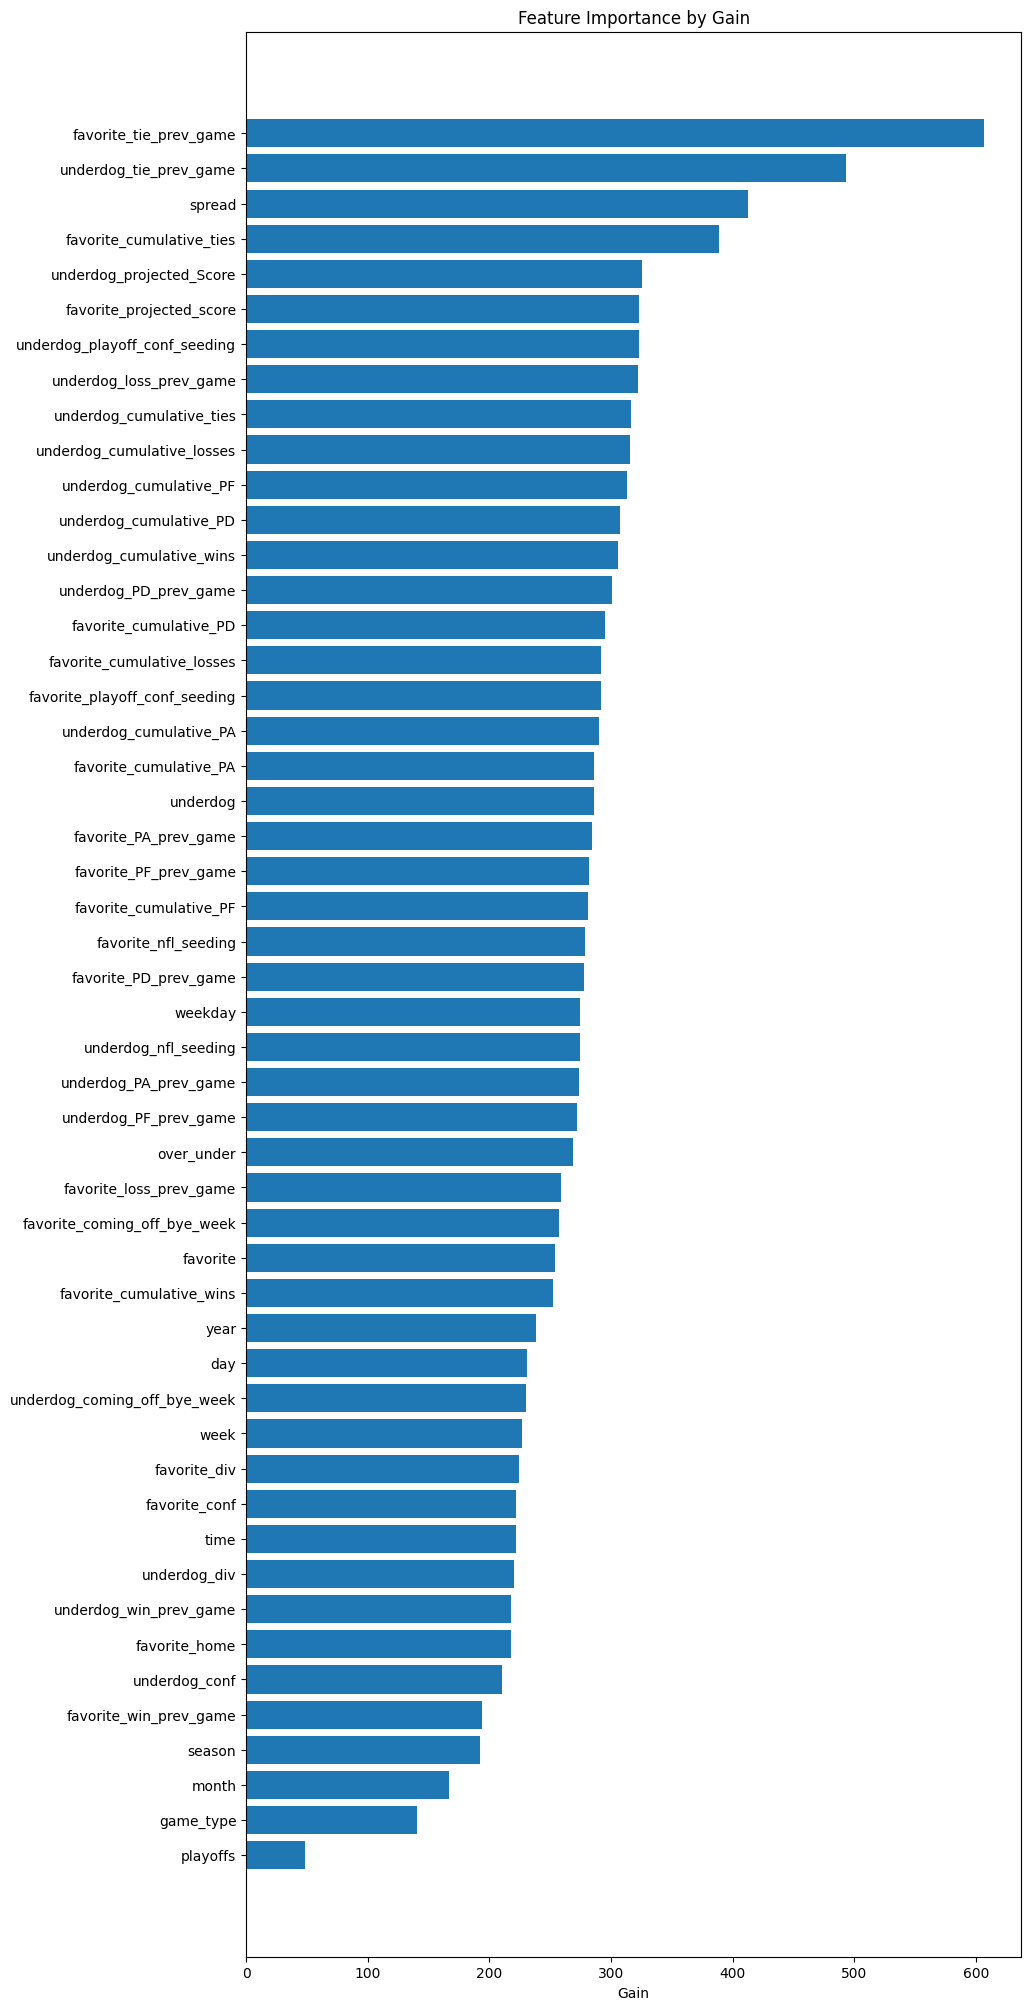

In [ ]:
# Extract feature importances and feature names
importance = XGB_model.get_booster().get_score(importance_type='gain')
features = list(importance.keys())
importances = list(importance.values())

# Sort features by importance
sorted_idx = sorted(range(len(importances)), key=lambda i: importances[i])

# Create the plot with enough height based on the number of features
plt.figure(figsize=(10, len(features) * 0.5))

# Plot bar chart manually
plt.barh([features[i] for i in sorted_idx], [importances[i] for i in sorted_idx])

# Show the plot
plt.xlabel('Gain')
plt.title('Feature Importance by Gain')
plt.show()

In [ ]:
predictions.head()

season  week  favorite  underdog  spread  predicted_spread  \
5660    2023     2        25        20    -6.0         -7.651872   
5661    2023     2        23         0    -4.5          1.541685   
5662    2023     2        19        21    -2.0         -6.494059   
5663    2023     2         9        31    -4.0         -0.579042   
5664    2023     2         8        24    -8.5         -9.305084   

      actual_spread  
5660             -6  
5661             -3  
5662             -7  
5663              2  
5664            -20

In [ ]:
# Decode team names
predictions['favorite'] = favorite_encoder.inverse_transform(predictions['favorite'])
predictions['underdog'] = underdog_encoder.inverse_transform(predictions['underdog'])

In [ ]:
# Add if favorite covered
predictions['covered'] = predictions.apply(lambda x: 1 if x['actual_spread'] < x['spread'] else 0 if x['actual_spread'] == x['spread'] else -1, axis=1)
predictions['predicted_covered'] = predictions.apply(lambda x: 1 if x['predicted_spread'] < x['spread'] else 0 if x['predicted_spread'] == x['spread'] else -1, axis=1)

In [ ]:
# Add confidence level


In [ ]:
predictions.head(16)

season  week              favorite               underdog  spread  \
5660    2023     2   Philadelphia Eagles      Minnesota Vikings    -6.0   
5661    2023     2       New York Giants      Arizona Cardinals    -4.5   
5662    2023     2        Miami Dolphins   New England Patriots    -2.0   
5663    2023     2        Denver Broncos  Washington Commanders    -4.0   
5664    2023     2        Dallas Cowboys          New York Jets    -8.5   
5665    2023     2   San Francisco 49ers       Los Angeles Rams    -7.5   
5666    2023     2  Los Angeles Chargers       Tennessee Titans    -2.5   
5667    2023     2    Cincinnati Bengals       Baltimore Ravens    -3.5   
5668    2023     2    Kansas City Chiefs   Jacksonville Jaguars    -3.5   
5669    2023     2        Houston Texans     Indianapolis Colts    -1.0   
5670    2023     2         Detroit Lions       Seattle Seahawks    -4.5   
5671    2023     2         Buffalo Bills      Las Vegas Raiders    -8.0   
5672    2023     2       Atlanta Falcons      Green Bay Packers    -3.0   
5673    2023     2  Tampa Bay Buccaneers          Chicago Bears    -2.5   
5674    2023     2    New Orleans Saints      Carolina Panthers    -3.0   
5675    2023     2      Cleveland Browns    Pittsburgh Steelers    -2.5   

      predicted_spread  actual_spread  covered  predicted_covered  
5660         -7.651872             -6        0                  1  
5661          1.541685             -3       -1                 -1  
5662         -6.494059             -7        1                  1  
5663         -0.579042              2       -1                 -1  
5664         -9.305084            -20        1                  1  
5665        -16.700045             -7       -1                  1  
5666         -5.312155              3       -1                  1  
5667          4.842457              3       -1                 -1  
5668        -11.137837             -8        1                  1  
5669          4.004545             11       -1                 -1  
5670          0.685818              6       -1                 -1  
5671        -19.155262            -28        1                  1  
5672         -8.411902             -1       -1                  1  
5673          0.254350            -10        1                 -1  
5674          1.475484             -3        0                 -1  
5675          3.991363              4       -1                 -1

In [ ]:
for week in predictions.week.unique():
  print(f'Week {week} Accuracy: {accuracy_score(predictions[predictions.week == week].covered, predictions[predictions.week == week].predicted_covered)}')

Week 1 Accuracy: 0.5
Week 2 Accuracy: 0.75
Week 3 Accuracy: 0.4375
Week 4 Accuracy: 0.375
Week 5 Accuracy: 0.6428571428571429
Week 6 Accuracy: 0.3333333333333333
Week 7 Accuracy: 0.5384615384615384
Week 8 Accuracy: 0.25
Week 9 Accuracy: 0.42857142857142855
Week 10 Accuracy: 0.42857142857142855
Week 11 Accuracy: 0.5714285714285714
Week 12 Accuracy: 0.5625
Week 13 Accuracy: 0.38461538461538464
Week 14 Accuracy: 0.4
Week 15 Accuracy: 0.3125
Week 16 Accuracy: 0.625
Week 17 Accuracy: 0.5
Week 18 Accuracy: 0.3125
Week 19 Accuracy: 0.5
Week 20 Accuracy: 0.5
Week 21 Accuracy: 0.0


In [ ]:
# Get indexes for the target year of predi

In [ ]:
# Create prediciton dataframe filled with labels and add predictions to it
prediciton_df = labels_df.copy()
prediciton_df['predicted_spread'] = predicitons



##

# Train Test Split

In [ ]:
nfl_df.head()

playoffs  game_type  season  year  month  day  week  weekday  time  \
0         0          6    2002  2002      9    5     1        4     1   
1         0          6    2002  2002      9    8     1        3     1   
2         0          6    2002  2002      9    8     1        3     0   
3         0          6    2002  2002      9    8     1        3     0   
4         0          6    2002  2002      9    8     1        3     2   

   favorite_conf  favorite_div  favorite_home  underdog_conf  underdog_div  \
0              1             3             -1              1             0   
1              1             0             -1              0             2   
2              0             3              1              1             3   
3              1             3             -1              0             3   
4              0             2              1              1             0   

   favorite  underdog  favorite_outright_result  favorite_score  \
0        27        23                         1              16   
1         8        12                        -1              10   
2        16        28                         1              31   
3        18         9                        -1              16   
4        30        25                         1              27   

   underdog_score  favorite_spread_result  spread  over_under_result  \
0              13                      -1    -4.0                 -1   
1              19                      -1    -8.5                 -1   
2              17                       1    -7.5                  1   
3              23                      -1    -3.0                 -1   
4              24                       1    -2.0                  1   

   over_under  favorite_playoff_conf_seeding  underdog_playoff_conf_seeding  \
0        39.0                              0                              0   
1        33.5                              0                              0   
2        40.0                              0                              0   
3        51.0                              0                              0   
4        37.0                              0                              0   

   favorite_coming_off_bye_week  underdog_coming_off_bye_week  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   favorite_win_prev_game  favorite_loss_prev_game  favorite_tie_prev_game  \
0                       0                        0                       0   
1                       0                        0                       0   
2                       0                        0                       0   
3                       0                        0                       0   
4                       0                        0                       0   

   favorite_cumulative_wins  favorite_cumulative_losses  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   favorite_cumulative_ties  underdog_win_prev_game  underdog_loss_prev_game  \
0                         0                       0                        0   
1                         0                       0                        0   
2                         0                       0                        0   
3                         0                       0                        0   
4                         0                       0                        0   

   underdog_tie_prev_game  underdog_cumulative_wins  \
0                       0        

In [ ]:
current_week = 10
current_season = 2023


# Start off with predicting week 1
training_set = nfl_df[~((nfl_df.season == current_season) & (nfl_df.week >= current_week))]

testing_set = nfl_df[(nfl_df.season == current_season) & (nfl_df.week == current_week)]

target_columns = ['favorite_outright_result', 'favorite_score', 'underdog_score', 'favorite_spread_result', 'over_under_result']

x_train = training_set.drop(columns=target_columns)
y_train = training_set[target_columns[3]]

x_test = testing_set.drop(columns=target_columns)
y_test = testing_set[target_columns[3]]

# Add in favorite and underdog projected scores
# Can do bucket analysis based on score projections like if higher scores win more spreads

In [ ]:
training_set.tail()

playoffs  game_type  season  year  month  day  week  weekday  time  \
5775         0          6    2023  2023     11    5     9        3     0   
5776         0          6    2023  2023     11    5     9        3     0   
5777         0          6    2023  2023     11    5     9        3     0   
5778         0          6    2023  2023     11    5     9        3     1   
5779         0          6    2023  2023     11    6     9        1     1   

      favorite_conf  favorite_div  favorite_home  underdog_conf  underdog_div  \
5775              0             2             -1              1             2   
5776              0             3              1              1             0   
5777              1             0              1              1             0   
5778              0             1              1              0             0   
5779              0             3             -1              0             0   

      favorite  underdog  favorite_outright_result  favorite_score  \
5775        13         4                         1              27   
5776        16        23                         1              30   
5777        25         8                         1              28   
5778         6         3                         1              24   
5779        17        24                         1              27   

      underdog_score  favorite_spread_result  spread  over_under_result  \
5775              13                       1    -1.5                 -1   
5776               6                       1    -1.5                 -1   
5777              23                       1    -3.0                  1   
5778              18                       1    -1.5                 -1   
5779               6                       1    -3.0                 -1   

      over_under  favorite_playoff_conf_seeding  \
5775        44.5                              0   
5776        38.5                              0   
5777        46.5                              0   
5778        50.5                              0   
5779        41.0                              0   

      underdog_playoff_conf_seeding  favorite_coming_off_bye_week  \
5775                              0                             0   
5776                              0                             0   
5777                              0                             0   
5778                              0                             0   
5779                              0                             0   

      underdog_coming_off_bye_week  favorite_win_prev_game  \
5775                             0                       0   
5776                             0                       0   
5777                             0                       1   
5778                             0                       1   
5779                             0                       1   

      favorite_loss_prev_game  favorite_tie_prev_game  \
5775                        1                       0   
5776                        1                       0   
5777                        0                       0   
5778                        0                       0   
5779                        0                       0   

      favorite_cumulative_wins  favorite_cumulative_losses  \
5775                         3                           5   
5776                         3                           5   
5777                         7                           1   
5778                         4                           3   
5779                         3                           4   

      favorite_cumulative_ties  underdog_win_prev_game  \
5775                         0                       1   
5776                         0                       0   
5777                         0                       1   
5778                         0                       1   
5779                         0                       1   

      underdog_loss_prev_game 

# Decision Tree

In [ ]:
def plot_feature_importance_heatmap(pipeline, feature_names, model_step_name='model'):
    # Access the decision tree model inside the pipeline
    model = pipeline.named_steps[model_step_name]

    # Extract feature importances
    importances = model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).set_index('Feature')

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(importance_df.T, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
    plt.title('Feature Importance Heatmap')
    plt.show()

Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

          -1       0.50      0.38      0.43         8
           1       0.38      0.50      0.43         6

    accuracy                           0.43        14
   macro avg       0.44      0.44      0.43        14
weighted avg       0.45      0.43      0.43        14



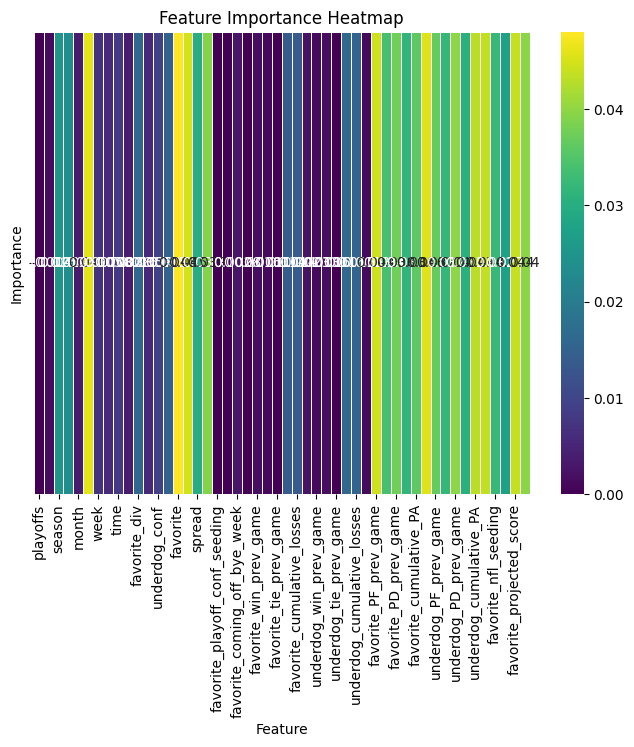

In [ ]:
tree_classifier = DecisionTreeClassifier(random_state = 69) # nice
pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('decision_tree', tree_classifier)
])

pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot the feature importance heatmap
plot_feature_importance_heatmap(pipeline, x_train.columns, model_step_name='decision_tree')

In [ ]:
# Access the decision tree model inside the pipeline
model = pipeline.named_steps['decision_tree']

# Extract feature importances
importances = model.feature_importances_

In [ ]:
importances

array([0.        , 0.00144858, 0.02502762, 0.02355296, 0.00341828,
       0.04602896, 0.00699055, 0.00579308, 0.00815725, 0.00379811,
       0.01574808, 0.00561185, 0.00929862, 0.01487508, 0.04801877,
       0.04498921, 0.0299239 , 0.03904365, 0.        , 0.        ,
       0.00277718, 0.        , 0.00155528, 0.00109243, 0.        ,
       0.01370884, 0.0136469 , 0.00225238, 0.00129949, 0.001569  ,
       0.        , 0.01610211, 0.01529011, 0.00119074, 0.04439155,
       0.03384697, 0.03765785, 0.03134474, 0.03606312, 0.0456889 ,
       0.03669178, 0.03206981, 0.03987313, 0.03051575, 0.04313045,
       0.04356718, 0.03211295, 0.02729546, 0.04387326, 0.03966809])